# Loading data

In [1]:
import os
import copy
import numpy
import modules.io as io
import modules.plot_func as pltt
import modules.traj_analysis as tran
import modules.helper_func_class as misc
import modules.process_mouse_trials_lib as plib
import matplotlib.pyplot as plt
import scipy.stats
import warnings

warnings.filterwarnings('ignore')
#import matplotlib.image as mpimg


"""

THE SUFFIXES IN THE VARIABLE NAMES

*** rt suffix -> relative target experiments
                 this means STATIC entrance,
                 since the target is always
                 positioned in the same spot
                 relative to the entrance
                 the mouse takes

*** ft suffix -> fixed target experiments
                 this means RANDOM entrance,
                 since the target is in a
                 different spot in every trial,
                 relative to the entrance the mouse
                 takes

*** 2t suffix -> two target experiments
                 mice are trained in two locations, consecutively

"""

mouse_traj_dir_rt      = r'./experiments/relative_target/mouse_*'
mouse_traj_dir_ft      = r'./experiments/fixed_target/mouse_*'
mouse_traj_dir_2t      = r'./experiments/two_target_no_cues/mouse_*'
mouse_traj_dir_p2_R180 = [r'./experiments/two_targets_rot/mouse_*'       ,
                          r'./experiments/two_targets_rot_fem/mouse_*'   ,
                          r'./experiments/two_targets_rot_mixsex/mouse_*']

selfint_file_variable  = 'selfint_st_rt'

output_dir = 'figs/paper/active_sensing'
try:
    os.makedirs(output_dir)
except FileExistsError:
    pass

colors = pltt.get_gradient(5,'blue2')

color_lightblue   = numpy.array((65, 102, 216, 255))/255 #pltt.get_gradient(5,'blue2')[2] #numpy.array((65, 102, 216, 255))/255
color_darkblue    = pltt.get_gradient(2,'blue')[1] #numpy.array((224, 53, 53, 255))/255
color_lightred    = pltt.get_gradient(2,'red')[0] #numpy.array((65, 102, 216, 255))/255 #pltt.get_gradient(5,'blue2')[2] #numpy.array((65, 102, 216, 255))/255
color_darkred     = pltt.get_gradient(2,'red')[1] #numpy.array((224, 53, 53, 255))/255
color_lightyellow = numpy.append(pltt.get_gradient(10,'yellow')[2],1.0)
color_darkyellow  = numpy.append(pltt.get_gradient(2,'yellow')[::-1][0],1.0)

color_h1 = color_lightblue
color_h2 = color_darkblue

SMALL_FONTSIZE  = 12
MEDIUM_FONTSIZE = 14
LARGE_FONTSIZE  = 16
plt.rc('font',        size=SMALL_FONTSIZE )  # controls default text sizes
plt.rc('axes',   titlesize=SMALL_FONTSIZE )  # fontsize of the axes title
plt.rc('axes',   labelsize=MEDIUM_FONTSIZE) # fontsize of the x and y labels
plt.rc('xtick',  labelsize=SMALL_FONTSIZE ) # fontsize of the tick labels
plt.rc('ytick',  labelsize=SMALL_FONTSIZE ) # fontsize of the tick labels
plt.rc('legend',  fontsize=SMALL_FONTSIZE ) # legend fontsize
plt.rc('figure', titlesize=LARGE_FONTSIZE ) # fontsize of the figure title


FIGSIZE_1PANEL = numpy.array((4,3),dtype=float)
AX_POS_1PANEL  = numpy.array( [ 0.125, 0.125, 0.9, 0.88 ] ) # [xmin,ymin,width,heigh]
AX_POS_2PANELS = numpy.array([   AX_POS_1PANEL/2.0,
                               [ 1.5*AX_POS_1PANEL[0]+AX_POS_1PANEL[2]/2,AX_POS_1PANEL[1]/2,AX_POS_1PANEL[2]/2-0.5*AX_POS_1PANEL[0],AX_POS_1PANEL[3]/2 ] ])


# linear regression aux function
linreg_lin_func = lambda x,lr: lr.intercept + lr.slope * x
linreg_pl_func  = lambda x,lr: numpy.exp(lr.intercept + numpy.log(x)*lr.slope)
linreg_exp_func = lambda x,lr: numpy.exp(lr.intercept + x*lr.slope)

# t-test aux function
p_significant = 0.05
q_FDR         = 0.05 # FDR-level for thresholding p_values correcting for false-discovery rate in multiple comparisons
check_significance = lambda ttest_res: ttest_res.pvalue < p_significant


# loads experiment MAT files from file path according to the parameters

time_delay_after_food  = 3.0 # sec

# all_trials[k][m] -> mouse m in trial k
all_trials_rt,trial_labels_rt = io.load_trial_file(mouse_traj_dir_rt,load_only_training_sessions_relative_target=True ,skip_15_relative_target=True ,use_extra_trials_relative_target=False,sort_by_trial=True,fix_nan=True,remove_after_food=False,align_to_top=True,group_by='trial',return_group_by_keys=True)
all_trials_ft,trial_labels_ft = io.load_trial_file(mouse_traj_dir_ft,load_only_training_sessions_relative_target=True ,skip_15_relative_target=True ,use_extra_trials_relative_target=False,sort_by_trial=True,fix_nan=True,remove_after_food=False,align_to_top=True,group_by='trial',return_group_by_keys=True,max_trial_number=len(all_trials_rt))
all_trials_ft_full,_          = io.load_trial_file(mouse_traj_dir_ft,load_only_training_sessions_relative_target=True ,skip_15_relative_target=False,use_extra_trials_relative_target=True ,sort_by_trial=True,fix_nan=True,remove_after_food=False,align_to_top=True,group_by='trial',return_group_by_keys=True,max_trial_number=18)
all_trials_rt_p1_complete     = io.load_trial_file(mouse_traj_dir_rt,file_name_expr='mpos_*Probe_*',load_only_training_sessions_relative_target=False,skip_15_relative_target=False,use_extra_trials_relative_target=True,remove_after_food=False,sort_by_trial=True,fix_nan=True,align_to_top=True)
all_trials_ft_p1_complete     = io.load_trial_file(mouse_traj_dir_ft,file_name_expr='mpos_*Probe_*',load_only_training_sessions_relative_target=False,skip_15_relative_target=False,use_extra_trials_relative_target=True,remove_after_food=False,sort_by_trial=True,fix_nan=True,align_to_top=True)
all_trials_rt                 = tran.remove_path_after_food(all_trials_rt,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)
all_trials_ft                 = tran.remove_path_after_food(all_trials_ft,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)
all_trials_ft_full            = tran.remove_path_after_food(all_trials_ft_full,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)
all_trials_rt_p1              = tran.remove_path_after_food(all_trials_rt_p1_complete,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,copy_tracks=True,time_delay_after_food=time_delay_after_food)
all_trials_ft_p1              = tran.remove_path_after_food(all_trials_ft_p1_complete,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,copy_tracks=True,time_delay_after_food=time_delay_after_food)

hole_horizon_rt_R180          = 5.0 # cm
get_hole_horiz_rt_R180        = lambda tr: hole_horizon_rt_R180 if int(tr.mouse_number) in [14,16] else None
all_trials_rt_R180            = io.load_trial_file(mouse_traj_dir_rt,file_name_expr='mpos_*_R180_1*',load_only_training_sessions_relative_target=False,skip_15_relative_target=True,use_extra_trials_relative_target=True,sort_by_trial=True,fix_nan=True,remove_after_food=False,group_by='none')#,max_trial_number=n_trials_to_use)
all_trials_rt_R180            = io.group_track_list([ tran.remove_path_after_food(tr,r_target=tr.r_target_reverse,return_t_to_food=False,force_main_target=False,hole_horizon=get_hole_horiz_rt_R180(tr),time_delay_after_food=0.0) for tr in all_trials_rt_R180 ],group_by='trial',return_group_keys=False)[0]
all_trials_rt_R180            = plib.rotate_trial_file(all_trials_rt_R180,(0,-1),return_only_track=True)


# 2 targets
n_trials_l1            = 18
nmax_trials_l2         = 26
n_trials_p2            = 1
hole_horizon           = 10.0 # cm
all_trials_l1          = io.load_trial_file(mouse_traj_dir_2t, load_only_training_sessions_relative_target=True, fix_nan=True,group_by='trial',return_group_by_keys=False,remove_after_food=False,max_trial_number=n_trials_l1)
all_trials_l2          = io.load_trial_file(mouse_traj_dir_2t, load_only_training_sessions_relative_target=True,align_to_top=True, fix_nan=True,group_by='trial',return_group_by_keys=False,remove_after_food=False,max_trial_number=nmax_trials_l2)
all_trials_p2_complete = io.load_trial_file(mouse_traj_dir_2t,file_name_expr='mpos_*Probe2_*',align_to_top=True,fix_nan=True,sort_by_trial=True,return_group_by_keys=False,remove_after_food=False)
all_trials_l1          = tran.remove_path_after_food(all_trials_l1,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)
all_trials_l2          = io.select_numeric_trials(all_trials_l2,trial0=n_trials_l1+1,trial1=nmax_trials_l2,get_trial_number_func=lambda tr: int(tr[0].trial))
all_trials_l2          = tran.remove_path_after_food(all_trials_l2,r_target=None,return_t_to_food=False,force_main_target=True,hole_horizon=None,time_delay_after_food=time_delay_after_food)
all_trials_p2          = tran.keep_path_between_targets(all_trials_p2_complete,return_t_in_targets=False,hole_horizon=hole_horizon,time_delay_after_food=time_delay_after_food,copy_tracks=True)


time_delay_after_food_R180 = 1.0
all_trials_p2_R180     = misc.flatten_list([
                                        io.load_trial_file(mouse_traj_dir_p2_R180,file_name_expr='mpos_*Probe2_*' ,align_to_top=True,fix_nan=True,sort_by_trial=True,return_group_by_keys=False,remove_after_food=False),
                                        io.load_trial_file(mouse_traj_dir_p2_R180,file_name_expr='mpos_*Probe_2_*',align_to_top=True,fix_nan=True,sort_by_trial=True,return_group_by_keys=False,remove_after_food=False),
                                    ], only_lists=True, return_list=True)
all_trials_p2_R180     = tran.keep_path_between_targets(all_trials_p2_R180,return_t_in_targets=False,hole_horizon=hole_horizon,time_delay_after_food=time_delay_after_food_R180,copy_tracks=True)
all_trials_p2_R180     = plib.rotate_trial_file(all_trials_p2_R180,(0,-1),return_only_track=True)
all_trials_p2_R180     = [ track for track in all_trials_p2_R180 if not(int(track.mouse_number) in [2,4,5,6,7,73,74,75]) ]

n_trials_h1 = 14 # 1st half
n_trials_h2 = 14 # 2nd half
n_trials = numpy.min((n_trials_h2,n_trials_h1))


save_output_figures = True

# Spatial distributions

## Static vs. random

### 20 cm radius example

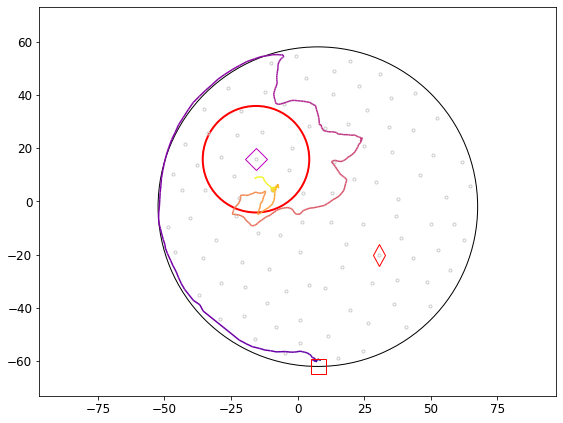

In [9]:
ax=pltt.plot_arena_sketch(all_trials_rt_R180[0],showAllEntrances=False,arenaPicture=False,showHoles=True)
pltt.plot_mouse_trajectory(ax,all_trials_rt_R180[0],mouse_part='nose',show_reverse_alt_target=True,show_reverse_target=True,show_alt_target=True,line_gradient_variable='time',show_colorbar=False)
pltt.draw_circle(all_trials_rt_R180[0].r_target_reverse,20.0,ax=ax,edgecolor='r',facecolor='none',linewidth=2)
plt.show()

### (within 20cm) near vs. general

 ... saving  figs/paper/active_sensing/distribution_hole_check_random_vs_static_3s_white.png


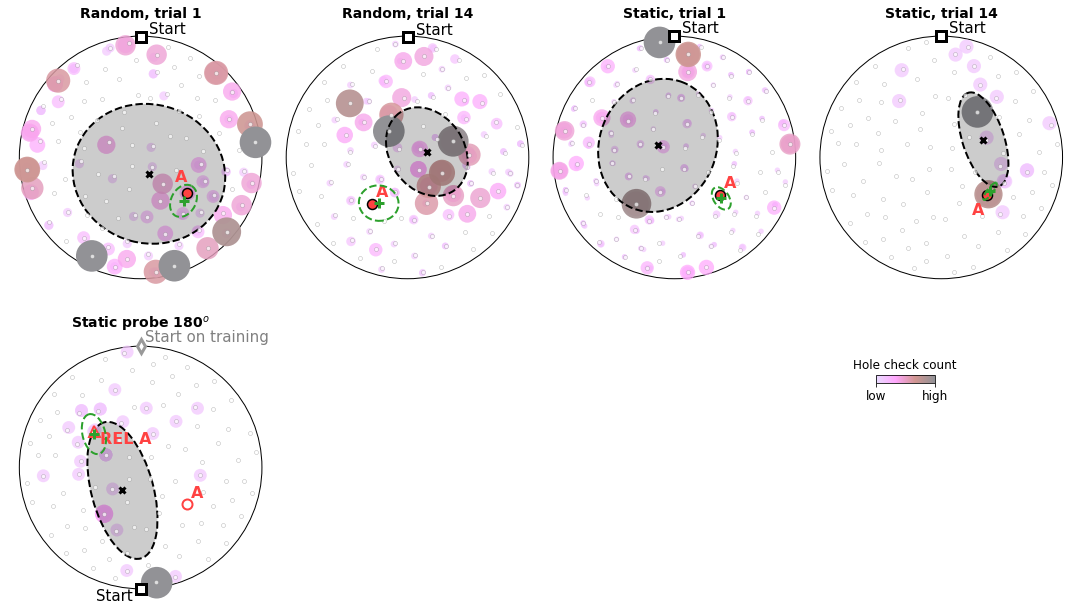

In [2]:
#import sys
#del sys.modules['modules.plot_func']
#del pltt
#import modules.plot_func as pltt

"""
###############
###############
###############
###############
############### P(check) -- trimmed trajectories, aligned targets
###############
###############
###############
###############
"""

#import sys
#del sys.modules['modules.plot_func']
#del pltt
#import modules.plot_func as pltt


ignore_entrance_positions = False
normalize_by              = 'max'
entrance_align_vector     = (0,1)


all_trials_rt_rot = plib.rotate_trial_file(copy.deepcopy(all_trials_rt),entrance_align_vector,True)
all_trials_ft_rot = plib.align_targets_group_by_start_quadrant(copy.deepcopy(all_trials_ft),entrance_align_vector)

trial_prev_label  = numpy.arange(len(all_trials_ft_rot))
r_target_prev_ft  = [numpy.ones(2)*numpy.nan]+[ trials[0].r_target for trials in all_trials_ft_rot ][:-1]

# calculating the slowing down instants and positions in the 3 cm radius of holes
hole_horizon            = 3.0 # in cm (units is mouse.unit_r)  
use_velocity_minima     = True
velocity_min_prominence = 5.0 # cm/s

hole_horizon_rt_R180    = 5.0 # cm
get_hole_horiz_rt_R180  = lambda tr: hole_horizon_rt_R180 if int(tr.mouse_number) in [14,16] else None






#d_holes_rt      = [ tran.calc_dist_checked_holes_target(all_mice,hole_horizon,threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False,ignore_entrance_positions=ignore_entrance_positions                ,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for all_mice       in all_trials_rt_rot                       ]
#d_holes_ft      = [ tran.calc_dist_checked_holes_target(all_mice,hole_horizon,threshold_method='ampv',gamma=0.1,return_pos_from='hole',use_reverse_target=False,ignore_entrance_positions=ignore_entrance_positions                ,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for all_mice       in all_trials_ft_rot                       ]
#
#n_checks_near_rt = numpy.asarray([ [ numpy.nonzero(d <= hole_proximity_radius_threshold)[0].size for d in trial ] for trial in d_holes_rt ],dtype=float)/area_near_tgt
#n_checks_far_rt  = numpy.asarray([ [ numpy.nonzero(d  > hole_proximity_radius_threshold)[0].size for d in trial ] for trial in d_holes_rt ],dtype=float)/area_far_tgt
#n_checks_near_ft = numpy.asarray([ [ numpy.nonzero(d <= hole_proximity_radius_threshold)[0].size for d in trial ] for trial in d_holes_ft ],dtype=float)/area_near_tgt
#n_checks_far_ft  = numpy.asarray([ [ numpy.nonzero(d  > hole_proximity_radius_threshold)[0].size for d in trial ] for trial in d_holes_ft ],dtype=float)/area_far_tgt





r_un_rt_3s  ,r_count_rt_3s  ,r_mean_rt_3s  ,r_cov_rt_3s  ,r_disp_rt_3s  ,r_eigdir_rt_3s   = misc.unpack_list_of_tuples([ tran.calc_number_of_checkings_per_hole(all_mice          ,hole_horizon,threshold_method='ampv',gamma=0.2,normalize_by=normalize_by,sort_result=True,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence                         ) for all_mice in all_trials_rt_rot ])
r_un_ft  ,r_count_ft  ,r_mean_ft  ,r_cov_ft  ,r_disp_ft  ,r_eigdir_ft   = misc.unpack_list_of_tuples([ tran.calc_number_of_checkings_per_hole(all_mice          ,hole_horizon,threshold_method='ampv',gamma=0.2,normalize_by=normalize_by,sort_result=True,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence,grouping_hole_horizon=10) for all_mice in all_trials_ft_rot ])
r_un_R180,r_count_R180,r_mean_R180,r_cov_R180,r_disp_R180,r_eigdir_R180 =                              tran.calc_number_of_checkings_per_hole(all_trials_rt_R180,hole_horizon,threshold_method='ampv',gamma=0.2,normalize_by=normalize_by,sort_result=True,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence                         )


d_near_target = 20.0 # cm; distance around target used to calculate the "near target dispersion of hole checks
r_un_rt_near  ,r_count_rt_near  ,r_mean_rt_near  ,r_cov_rt_near  ,r_disp_rt_near  ,r_eigdir_rt_near   = misc.unpack_list_of_tuples([ tran.calc_number_of_checkings_per_hole(all_mice          ,hole_horizon,threshold_method='ampv',gamma=0.2,normalize_by=normalize_by,sort_result=True,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence                         ,r0=all_mice[0].r_target                   , radius_of_interest=d_near_target) for all_mice in all_trials_rt_rot ])
r_un_ft_near  ,r_count_ft_near  ,r_mean_ft_near  ,r_cov_ft_near  ,r_disp_ft_near  ,r_eigdir_ft_near   = misc.unpack_list_of_tuples([ tran.calc_number_of_checkings_per_hole(all_mice          ,hole_horizon,threshold_method='ampv',gamma=0.2,normalize_by=normalize_by,sort_result=True,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence,grouping_hole_horizon=10,r0=all_mice[0].r_target                   , radius_of_interest=d_near_target) for all_mice in all_trials_ft_rot ])
r_un_R180_near,r_count_R180_near,r_mean_R180_near,r_cov_R180_near,r_disp_R180_near,r_eigdir_R180_near =                              tran.calc_number_of_checkings_per_hole(all_trials_rt_R180,hole_horizon,threshold_method='ampv',gamma=0.2,normalize_by=normalize_by,sort_result=True,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence                         ,r0=all_trials_rt_R180[0].r_target_reverse , radius_of_interest=d_near_target)

show_panel_labels = False
is_dark_bg        = False
get_color         = lambda c_is_dark,c_not_dark: c_is_dark if is_dark_bg else c_not_dark
cmap_name         = pltt.get_cmap_plasma_inv_lum() #'plasma'
point_size        = 1e3
color_bg_dark     = plt.get_cmap(cmap_name)(numpy.linspace(0,1,100))[0]
color_red         = numpy.array((255, 66, 66,255))/255
color_blue        = numpy.array(( 10, 30,211,255))/255
color_green       = numpy.array(( 34,201, 98,255))/255# if is_dark_bg else numpy.array((17, 112, 50,255))/255
alpha_alt_target  = 0.35

#fig,ax=plt.subplots(nrows=1,ncols=4,figsize=(22,8))
fig,ax=plt.subplots(nrows=2,ncols=4,figsize=(22,12))
fig.patch.set_facecolor(get_color('k','w'))

default_panel_param  = dict(show_holes=True,holes_args=dict(markersize=4,markeredgewidth=0.4,color=0.5*numpy.ones(3),markerfacecolor=numpy.array((1,1,1,0.7)),fillstyle='full'),
                            panel_label_args=None,target1_label_args=None,is_dark_bg=is_dark_bg,cmap_name=cmap_name,
                            point_size=point_size,color_bg_dark='#000000',cmap_start_fraction=0.15,
                            start_args=dict(markerfacecolor='w',fillstyle='full',markeredgecolor='k',markeredgewidth=3),
                            scatter_args=dict(min_alpha=0.7),
                            ellipse_args=dict(facecolor=numpy.array((0,0,0,0.2))))
plot_args_panel_ft1  = pltt._get_kwargs(dict(scatter_args       = dict(min_alpha=0.65),show_start=True,start_label_args=dict(fontsize=15,ha='left',va='bottom',pad=(4,0)),
                                             panel_label        = 'Random, trial 1'      ,
                                             panel_label_args   = dict(fontdict=dict(fontsize=26,fontweight='bold')),
                                             target1_label      = 'A',
                                             target1_label_args = dict(ha='right',va='bottom',pad=(0,4)),
                                             color_target1      = color_red , alpha_target1=1.0,
                                             target2_label      = 'B',
                                             target1_args       = dict(markersize=10,markeredgewidth=1.5),
                                             color_target2      = color_blue,alpha_target2=1.0),**default_panel_param)
plot_args_panel_ft2  = pltt._get_kwargs(dict(scatter_args       = dict(min_alpha=0.65),show_start=True,start_label_args=dict(fontsize=15,ha='left',va='bottom',pad=(4,0)),
                                             panel_label        = 'Random, trial 14'     ,
                                             panel_label_args   = dict(fontdict=dict(fontsize=26,fontweight='bold')),
                                             target1_label      ='A',
                                             target1_label_args = dict()                                ,
                                             color_target1      = color_red , alpha_target1=1.0,
                                             target2_label      = 'B',
                                             target1_args       = dict(markersize=10,markeredgewidth=1.5),
                                             color_target2      = color_blue, alpha_target2=1.0),**default_panel_param)
plot_args_panel_rt1  = pltt._get_kwargs(dict(scatter_args       = dict(min_alpha=0.65),show_start=True,start_label_args=dict(fontsize=15,ha='left',va='bottom',pad=(4,0)),
                                             panel_label        = 'Static, trial 1'      ,
                                             panel_label_args   = dict(fontdict=dict(fontsize=26,fontweight='bold')),
                                             target1_label      = 'A',
                                             target1_label_args = dict()                                ,
                                             color_target1      = color_red ,alpha_target1=1.0,
                                             target2_label      = 'B',
                                             target1_args       = dict(markersize=10,markeredgewidth=1.5),
                                             color_target2      = color_blue,alpha_target2=1.0),**default_panel_param)
plot_args_panel_rt2  = pltt._get_kwargs(dict(scatter_args       = dict(min_alpha=0.65),show_start=True,start_label_args=dict(fontsize=15,ha='left',va='bottom',pad=(4,0)),
                                             panel_label        = 'Static, trial 14'     ,
                                             panel_label_args   = dict(fontdict=dict(fontsize=26,fontweight='bold')),
                                             target1_label      = 'A',
                                             target1_label_args = dict(ha='right',va='top',pad=(-1,-4)) ,
                                             color_target1      = color_red ,alpha_target1=1.0,
                                             target2_label      = 'B',
                                             target1_args       = dict(markersize=10,markeredgewidth=1.5),
                                             color_target2      = color_blue,alpha_target2=1.0),**default_panel_param)
plot_args_panel_R180 = pltt._get_kwargs(dict(scatter_args       = dict(min_alpha=0.65),show_start=True,start_label_args=dict(fontsize=15,ha='right',va='top'   ,pad=(-4,0)),
                                             panel_label        = 'Static probe 180$^o$' ,
                                             panel_label_args   = dict(fontdict=dict(fontsize=26,fontweight='bold')),
                                             target1_label      = 'A',
                                             target1_label_args = dict()                                ,
                                             color_target1      = color_red ,alpha_target1=1.0,
                                             target2_label      = 'REL A',
                                             target2_label_args = dict(va='top',ha='left',pad=(3,0)),
                                             target1_args       = dict(marker='o',markersize=10,markerfacecolor='w',markeredgewidth=2,fillstyle='full'),
                                             target2_args       = dict(marker='^',markersize=11,markerfacecolor='w',markeredgewidth=2,fillstyle='full'),
                                             color_target2      = color_red ,alpha_target2=1.0,
                                             is_target1_present=False,is_target2_present=False), **default_panel_param)
pltt._plot_hole_check_spatial_distribution(all_trials_ft_rot[0][0] ,r_un_ft[0] ,r_count_ft[0] ,all_trials_ft_rot[0][0].r_target ,r_mean_ft[0] ,r_eigdir_ft[0] ,r_disp_ft[0] , ax=ax[0,0], **plot_args_panel_ft1)
pltt._plot_hole_check_spatial_distribution(all_trials_ft_rot[-1][0],r_un_ft[-1],r_count_ft[-1],all_trials_ft_rot[-1][0].r_target,r_mean_ft[-1],r_eigdir_ft[-1],r_disp_ft[-1], ax=ax[0,1], **plot_args_panel_ft2)
pltt._plot_hole_check_spatial_distribution(all_trials_rt_rot[0][0] ,r_un_rt_3s[0] ,r_count_rt_3s[0] ,all_trials_rt_rot[0][0].r_target ,r_mean_rt_3s[0] ,r_eigdir_rt_3s[0] ,r_disp_rt_3s[0] , ax=ax[0,2], **plot_args_panel_rt1)
pltt._plot_hole_check_spatial_distribution(all_trials_rt_rot[-1][0],r_un_rt_3s[-1],r_count_rt_3s[-1],all_trials_rt_rot[-1][0].r_target,r_mean_rt_3s[-1],r_eigdir_rt_3s[-1],r_disp_rt_3s[-1], ax=ax[0,3], **plot_args_panel_rt2)
pltt._plot_hole_check_spatial_distribution(all_trials_rt_R180[0]   ,r_un_R180  ,r_count_R180  ,all_trials_rt_R180[0].r_target   ,r_mean_R180  ,r_eigdir_R180  ,r_disp_R180  , ax=ax[1,0], r_target2=all_trials_rt_R180[0].r_target_reverse , **plot_args_panel_R180)

ellipse_args        = dict(show_center=True, facecolor='none', edgecolor='tab:green', linestyle='--', linewidth=2, zorder=10000)
ellipse_center_args = dict(markersize=10,markeredgewidth=3,color='tab:green',marker='+',zorder=10001)
pltt.plot_dispersion(r_mean_ft_near[0] ,r_eigdir_ft_near[0] ,r_disp_ft_near[0] , ax=ax[0,0], center_args=ellipse_center_args, **ellipse_args)
pltt.plot_dispersion(r_mean_ft_near[-1],r_eigdir_ft_near[-1],r_disp_ft_near[-1], ax=ax[0,1], center_args=ellipse_center_args, **ellipse_args)
pltt.plot_dispersion(r_mean_rt_near[0] ,r_eigdir_rt_near[0] ,r_disp_rt_near[0] , ax=ax[0,2], center_args=ellipse_center_args, **ellipse_args)
pltt.plot_dispersion(r_mean_rt_near[-1],r_eigdir_rt_near[-1],r_disp_rt_near[-1], ax=ax[0,3], center_args=ellipse_center_args, **ellipse_args)
pltt.plot_dispersion(r_mean_R180_near  ,r_eigdir_R180_near  ,r_disp_R180_near  , ax=ax[1,0], center_args=ellipse_center_args, **ellipse_args)






#pltt.draw_ellipse(r_center,axes_direction,semi_axis_length,ax=None,show_center=False,center_args=None,**ellipse_args)

r_start_training = all_trials_rt_R180[0].r_start.copy();r_start_training[1] = -r_start_training[1]-4.0
pltt.plot_point(r_start_training,'Start on training',ax=ax[1,0],fmt='d',color=0.6*numpy.ones(3),pointArgs=dict(markeredgewidth=3,markersize=10,markerfacecolor='w',fillstyle='full'),pad=(2,2),ha='left',fontsize=15,labelcolor=0.5*numpy.ones(3))

#pltt.plot_point(r_target_prev_ft[-3],fmt='o',color=color_green ,markersize=6, ax=ax[1], pointArgs=dict(markeredgewidth=3, label='A$_{trial\\ %d}$'%trial_prev_label[-3],labelArgs=dict(fontsize=16,va='top',ha='right' , fontweight='bold',color=color_green ,pad=(2,-3)                           )))
#pltt.plot_point(r_target_prev_ft[-2],fmt='o',color=color_green ,markersize=6, ax=ax[1], pointArgs=dict(markeredgewidth=3, label='A$_{trial\\ %d}$'%trial_prev_label[-2],labelArgs=dict(fontsize=16,va='top',ha='right' , fontweight='bold',color=color_green ,pad=(2,-3) , backgroundcolor=get_color((0,0,0,0),(1,1,1,0.7))                          )))
#pltt.plot_point(r_target_prev_ft[-1],fmt='o',color=color_green ,markersize=6, ax=ax[1], pointArgs=dict(markeredgewidth=3, label='A$_{trial\\ %d}$'%trial_prev_label[-1],labelArgs=dict(fontsize=16,va='top',ha='left'  , fontweight='bold',color=color_green ,pad=(0,-3) , backgroundcolor=get_color((0,0,0,0),(1,1,1,0.7))                          )))

ax  = pltt.tight_arena_panels(ax,set_axis_off=True,adjust_title_position=False)
pltt.widen_axes_distance(ax,dy=-0.05)
cax = pltt._add_colorbar(ax[0,3],cmap_name,w_fraction_of_ax=0.22,h_fraction_of_ax=0.03,p0=(0.5,-0.3),minmax_tick_labels=('low','high'),orientation='horizontal',title='Hole check count',titleArgs=dict(color=get_color('w','k'),fontsize=12),ticklabelsArgs=dict(color=get_color('w','k')))

if save_output_figures:
    dark_label = 'dark' if is_dark_bg else 'white'
    fileName =  f'{output_dir}/distribution_hole_check_random_vs_static_{time_delay_after_food:g}s_{dark_label}.png'
    print(' ... saving ', fileName)
    plt.savefig( fileName,format='png',dpi=300,facecolor=get_color((0,0,0,1),(1,1,1,1)),bbox_inches='tight')

plt.show()

In [14]:
#[ (rr.min(),rr.min()) for rr in r_count_rt[[0,-1]] ]
print('Random target')
print('min,max first trial:  ({0:g},{1:g})'.format(r_count_ft[0].min(),  r_count_ft[0].max()))
print('min,max last  trial:  ({0:g},{1:g})'.format(r_count_ft[-1].min(), r_count_ft[-1].max()))

#[ (rr.min(),rr.min()) for rr in r_count_rt[[0,-1]] ]
print('Static target')
print('min,max first trial:  ({0:g},{1:g})'.format(r_count_rt_3s[0].min(),  r_count_rt_3s[0].max()))
print('min,max last  trial:  ({0:g},{1:g})'.format(r_count_rt_3s[-1].min(), r_count_rt_3s[-1].max()))

Random target
min,max first trial:  (0.0833333,1)
min,max last  trial:  (0.047619,1)
Static target
min,max first trial:  (0.0294118,1)
min,max last  trial:  (0.2,1)


### (within 3s) near vs general

 *** saving ...  figs/paper/active_sensing/distribution_3_SECONDS_hole_check_random_vs_static_3s_white.png


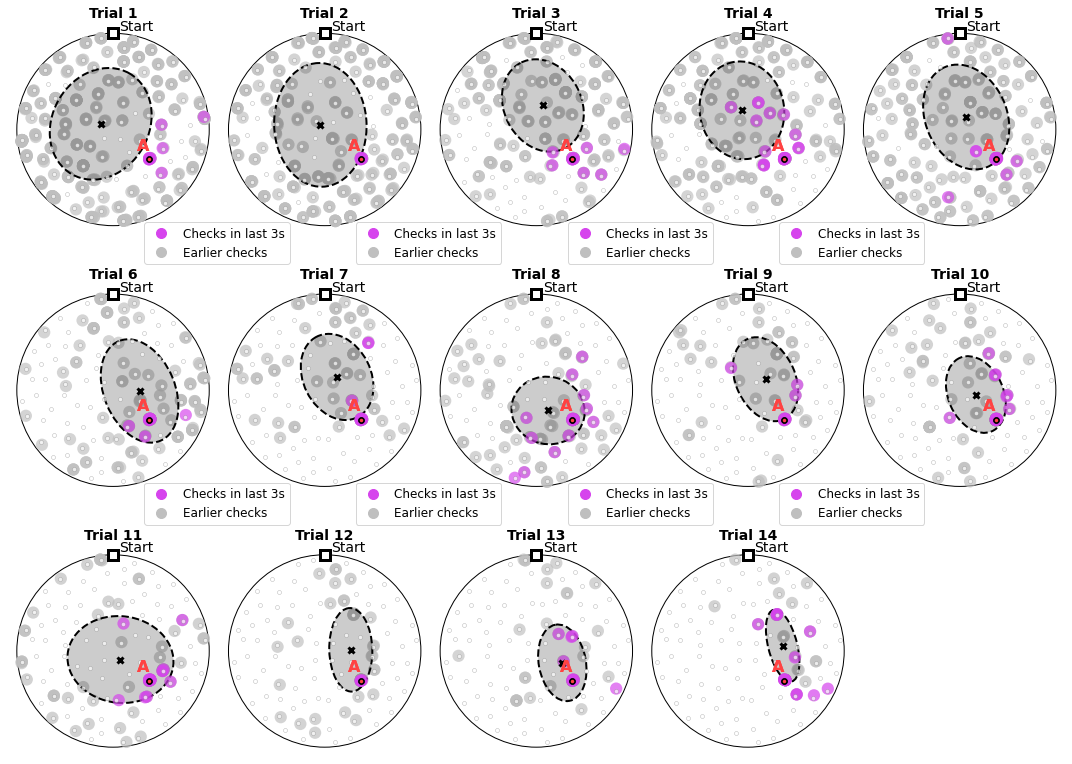

In [4]:
#import sys
#del sys.modules['modules.traj_analysis']
#del tran
#import modules.traj_analysis as tran

#import sys
#del sys.modules['modules.plot_func']
#del pltt
#import modules.plot_func as pltt

"""
###############
###############
###############
###############
############### P(check) -- trimmed trajectories, aligned targets
###############
###############
###############
###############
"""

#import sys
#del sys.modules['modules.plot_func']
#del pltt
#import modules.plot_func as pltt


ignore_entrance_positions = False
normalize_by              = 'max'
entrance_align_vector     = (0,1)

time_delay_before_end     = 3.0 + time_delay_after_food
show_arena_holes          = True
scale_point_size          = False
scale_color               = False
point_size                = 150
target_size               = 5
holes_size                = 4
color_checks_single       = numpy.array((214, 68, 237),dtype=float).reshape((1,3))/255
gray_shade_out_of_3s      = 0.75*numpy.ones((1,3))

all_trials_rt_rot   = plib.rotate_trial_file(copy.deepcopy(all_trials_rt),entrance_align_vector,True)
all_trials_rt_3s    = tran.slice_track_by_time(all_trials_rt_rot,dt= time_delay_before_end)
all_trials_rt_out3s = tran.slice_track_by_time(all_trials_rt_rot,dt=-time_delay_before_end)


# calculating the slowing down instants and positions in the 3 cm radius of holes
hole_horizon            = 3.5 # in cm (units is mouse.unit_r)  
use_velocity_minima     = True
velocity_min_prominence = 5.0 # cm/s



r_un_rt_3s  ,r_count_rt_3s  ,r_mean_rt_3s  ,r_cov_rt_3s  ,r_disp_rt_3s  ,r_eigdir_rt_3s   = misc.unpack_list_of_tuples([ tran.calc_number_of_checkings_per_hole(all_mice          ,hole_horizon,threshold_method='ampv',gamma=0.2,normalize_by=normalize_by,sort_result=True,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence                         ) for all_mice in all_trials_rt_3s    ])
r_un_rt     ,r_count_rt     ,r_mean_rt     ,r_cov_rt     ,r_disp_rt     ,r_eigdir_rt      = misc.unpack_list_of_tuples([ tran.calc_number_of_checkings_per_hole(all_mice          ,hole_horizon,threshold_method='ampv',gamma=0.2,normalize_by=normalize_by,sort_result=True,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence                         ) for all_mice in all_trials_rt_rot   ])


#d_near_target = 20.0 # cm; distance around target used to calculate the "near target dispersion of hole checks
#r_un_rt_near  ,r_count_rt_near  ,r_mean_rt_near  ,r_cov_rt_near  ,r_disp_rt_near  ,r_eigdir_rt_near   = misc.unpack_list_of_tuples([ tran.calc_number_of_checkings_per_hole(all_mice          ,hole_horizon,threshold_method='ampv',gamma=0.2,normalize_by=normalize_by,sort_result=True,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence                         ,r0=all_mice[0].r_target                   , radius_of_interest=d_near_target) for all_mice in all_trials_rt_rot ])
#r_un_ft_near  ,r_count_ft_near  ,r_mean_ft_near  ,r_cov_ft_near  ,r_disp_ft_near  ,r_eigdir_ft_near   = misc.unpack_list_of_tuples([ tran.calc_number_of_checkings_per_hole(all_mice          ,hole_horizon,threshold_method='ampv',gamma=0.2,normalize_by=normalize_by,sort_result=True,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence,grouping_hole_horizon=10,r0=all_mice[0].r_target                   , radius_of_interest=d_near_target) for all_mice in all_trials_ft_rot ])
#r_un_R180_near,r_count_R180_near,r_mean_R180_near,r_cov_R180_near,r_disp_R180_near,r_eigdir_R180_near =                              tran.calc_number_of_checkings_per_hole(all_trials_rt_R180,hole_horizon,threshold_method='ampv',gamma=0.2,normalize_by=normalize_by,sort_result=True,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence                         ,r0=all_trials_rt_R180[0].r_target_reverse , radius_of_interest=d_near_target)

show_panel_labels = False
is_dark_bg        = False
get_color         = lambda c_is_dark,c_not_dark: c_is_dark if is_dark_bg else c_not_dark
cmap_name         = pltt.get_cmap_plasma_inv_lum() #'plasma'
color_bg_dark     = plt.get_cmap(cmap_name)(numpy.linspace(0,1,100))[0]
color_red         = numpy.array((255, 66, 66,255))/255
color_blue        = numpy.array(( 10, 30,211,255))/255
color_green       = numpy.array(( 34,201, 98,255))/255# if is_dark_bg else numpy.array((17, 112, 50,255))/255
alpha_alt_target  = 0.35

trials_to_plot = numpy.arange(14)#numpy.array([ 0, 1, 4, 5, 6, 7, 12, 13 ])

fig,ax=plt.subplots(nrows=3,ncols=5,figsize=(22,22))
fig.patch.set_facecolor(get_color('k','w'))

default_panel_param  = dict(holes_args=dict(markersize=holes_size,markeredgewidth=0.4,color=0.5*numpy.ones(3),markerfacecolor=numpy.array((1,1,1,0.7)),fillstyle='full'),
                            panel_label_args=None,target1_label_args=None,is_dark_bg=is_dark_bg,cmap_name=cmap_name,
                            color_bg_dark='#000000',cmap_start_fraction=0.15,
                            start_args=dict(markerfacecolor='w',fillstyle='full',markeredgecolor='k',markeredgewidth=3),
                            scatter_args=dict(min_alpha=1.0),
                            ellipse_args=dict(facecolor=numpy.array((0,0,0,0.2))),
                            scale_point_size=scale_point_size,point_size=point_size,scale_color=scale_color)
plot_args_panel_rt1  = pltt._get_kwargs(dict(scatter_args       = dict(min_alpha=0.65),show_start=True,start_label_args=dict(fontsize=14,ha='left',va='bottom',pad=(4,0)),
                                             panel_label_args   = dict(fontdict=dict(fontsize=26,fontweight='bold')),
                                             target1_label      = 'A',
                                             target1_label_args = dict(ha='right',va='bottom',pad=(0,4)),
                                             color_target1      = color_red , alpha_target1=1.0,
                                             target2_label      = 'B',
                                             target1_args       = dict(markersize=target_size,markeredgewidth=1.5),
                                             color_target2      = color_blue,alpha_target2=1.0),**default_panel_param)
for k,(trial,aax) in enumerate(zip(trials_to_plot,ax.flatten()[:trials_to_plot.size])):
    pltt._plot_hole_check_spatial_distribution(all_trials_rt_rot[trial][0],
                                                         r_un_rt[trial],
                                                      r_count_rt[trial],
                                               all_trials_rt_rot[trial][0].r_target,
                                                       r_mean_rt[trial],
                                                     r_eigdir_rt[trial],
                                                       r_disp_rt[trial],
                                               ax=aax, color_checks_single=gray_shade_out_of_3s, show_holes=show_arena_holes, show_dispersion=True, **plot_args_panel_rt1)
    pltt._plot_hole_check_spatial_distribution(all_trials_rt_3s[trial][0],
                                                     r_un_rt_3s[trial],
                                                  r_count_rt_3s[trial],
                                               all_trials_rt_3s[trial][0].r_target,
                                                   r_mean_rt_3s[trial],
                                                 r_eigdir_rt_3s[trial],
                                                   r_disp_rt_3s[trial],
                                               ax=aax, panel_label=f'Trial {trial+1}', color_checks_single=color_checks_single, show_holes=False, show_arena=False, show_dispersion=False, **plot_args_panel_rt1)
    aax.plot(numpy.nan,numpy.nan,'o',c=color_checks_single ,markersize=10,label=f'Checks in last {time_delay_before_end-time_delay_after_food:g}s')
    aax.plot(numpy.nan,numpy.nan,'o',c=gray_shade_out_of_3s,markersize=10,label= 'Earlier checks'   )

#ellipse_args        = dict(show_center=True, facecolor='none', edgecolor='tab:green', linestyle='--', linewidth=2, zorder=10000)
#ellipse_center_args = dict(markersize=10,markeredgewidth=3,color='tab:green',marker='+',zorder=10001)
#pltt.plot_dispersion(r_mean_rt_near[ 0],r_eigdir_rt_near[ 0],r_disp_rt_near[ 0], ax=ax[0,0], center_args=ellipse_center_args, **ellipse_args)
#pltt.plot_dispersion(r_mean_rt_near[ 1],r_eigdir_rt_near[ 1],r_disp_rt_near[ 1], ax=ax[0,1], center_args=ellipse_center_args, **ellipse_args)
#pltt.plot_dispersion(r_mean_rt_near[ 5],r_eigdir_rt_near[ 5],r_disp_rt_near[ 5], ax=ax[0,2], center_args=ellipse_center_args, **ellipse_args)
#pltt.plot_dispersion(r_mean_rt_near[13],r_eigdir_rt_near[13],r_disp_rt_near[13], ax=ax[0,3], center_args=ellipse_center_args, **ellipse_args)

ax  = pltt.tight_arena_panels(ax,set_axis_off=True,adjust_title_position=False)
pltt.widen_axes_distance(ax,dy=-0.031)

ax[0,0].legend(loc='upper left', bbox_to_anchor=(0.62,0.09), fontsize=12)
ax[0,1].legend(loc='upper left', bbox_to_anchor=(0.62,0.09), fontsize=12)
ax[0,2].legend(loc='upper left', bbox_to_anchor=(0.62,0.09), fontsize=12)
ax[0,3].legend(loc='upper left', bbox_to_anchor=(0.62,0.09), fontsize=12)
ax[1,0].legend(loc='upper left', bbox_to_anchor=(0.62,0.09), fontsize=12)
ax[1,1].legend(loc='upper left', bbox_to_anchor=(0.62,0.09), fontsize=12)
ax[1,2].legend(loc='upper left', bbox_to_anchor=(0.62,0.09), fontsize=12)
ax[1,3].legend(loc='upper left', bbox_to_anchor=(0.62,0.09), fontsize=12)

#fig.suptitle('Static entrance hole checks',fontweight='bold',fontsize=17)

if save_output_figures:
    dark_label = 'dark' if is_dark_bg else 'white'
    pltt.savefig(f'{output_dir}/distribution_{time_delay_before_end-time_delay_after_food:g}_SECONDS_hole_check_random_vs_static_{time_delay_after_food:g}s_{dark_label}.png',format='png',dpi=300,facecolor=get_color((0,0,0,1),(1,1,1,1)),bbox_inches='tight')

plt.show()

### (within 5s) near vs general

 ... saving  figs/paper/active_sensing/distribution_5_SECONDS_hole_check_random_vs_static_3s_white.png


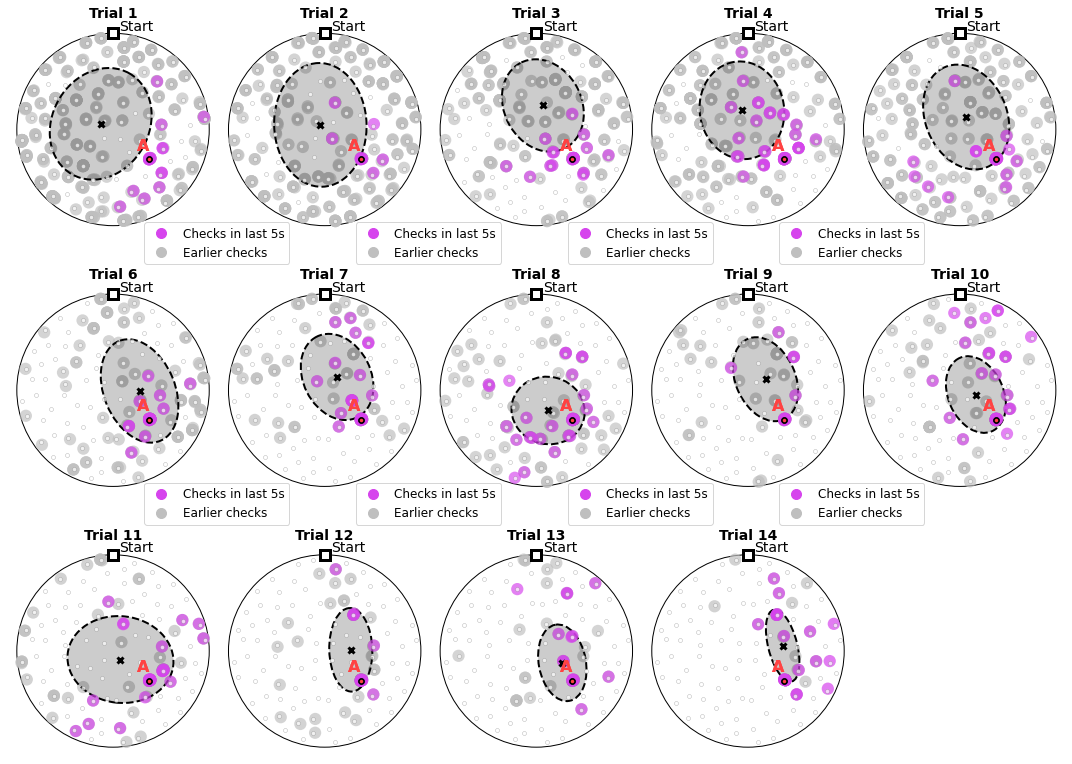

In [68]:
#import sys
#del sys.modules['modules.traj_analysis']
#del tran
#import modules.traj_analysis as tran

#import sys
#del sys.modules['modules.plot_func']
#del pltt
#import modules.plot_func as pltt

"""
###############
###############
###############
###############
############### P(check) -- trimmed trajectories, aligned targets
###############
###############
###############
###############
"""

#import sys
#del sys.modules['modules.plot_func']
#del pltt
#import modules.plot_func as pltt


ignore_entrance_positions = False
normalize_by              = 'max'
entrance_align_vector     = (0,1)

time_delay_before_end     = 5.0 + time_delay_after_food
show_arena_holes          = True
scale_point_size          = False
scale_color               = False
point_size                = 150
target_size               = 5
holes_size                = 4
color_checks_single       = numpy.array((214, 68, 237),dtype=float).reshape((1,3))/255
gray_shade_out_of_3s      = 0.75*numpy.ones((1,3))

all_trials_rt_rot   = plib.rotate_trial_file(copy.deepcopy(all_trials_rt),entrance_align_vector,True)
all_trials_rt_3s    = tran.slice_track_by_time(all_trials_rt_rot,dt= time_delay_before_end)
all_trials_rt_out3s = tran.slice_track_by_time(all_trials_rt_rot,dt=-time_delay_before_end)


# calculating the slowing down instants and positions in the 3 cm radius of holes
hole_horizon            = 3.5 # in cm (units is mouse.unit_r)  
use_velocity_minima     = True
velocity_min_prominence = 5.0 # cm/s



r_un_rt_3s  ,r_count_rt_3s  ,r_mean_rt_3s  ,r_cov_rt_3s  ,r_disp_rt_3s  ,r_eigdir_rt_3s   = misc.unpack_list_of_tuples([ tran.calc_number_of_checkings_per_hole(all_mice          ,hole_horizon,threshold_method='ampv',gamma=0.2,normalize_by=normalize_by,sort_result=True,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence                         ) for all_mice in all_trials_rt_3s    ])
r_un_rt     ,r_count_rt     ,r_mean_rt     ,r_cov_rt     ,r_disp_rt     ,r_eigdir_rt      = misc.unpack_list_of_tuples([ tran.calc_number_of_checkings_per_hole(all_mice          ,hole_horizon,threshold_method='ampv',gamma=0.2,normalize_by=normalize_by,sort_result=True,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence                         ) for all_mice in all_trials_rt_rot   ])


#d_near_target = 20.0 # cm; distance around target used to calculate the "near target dispersion of hole checks
#r_un_rt_near  ,r_count_rt_near  ,r_mean_rt_near  ,r_cov_rt_near  ,r_disp_rt_near  ,r_eigdir_rt_near   = misc.unpack_list_of_tuples([ tran.calc_number_of_checkings_per_hole(all_mice          ,hole_horizon,threshold_method='ampv',gamma=0.2,normalize_by=normalize_by,sort_result=True,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence                         ,r0=all_mice[0].r_target                   , radius_of_interest=d_near_target) for all_mice in all_trials_rt_rot ])
#r_un_ft_near  ,r_count_ft_near  ,r_mean_ft_near  ,r_cov_ft_near  ,r_disp_ft_near  ,r_eigdir_ft_near   = misc.unpack_list_of_tuples([ tran.calc_number_of_checkings_per_hole(all_mice          ,hole_horizon,threshold_method='ampv',gamma=0.2,normalize_by=normalize_by,sort_result=True,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence,grouping_hole_horizon=10,r0=all_mice[0].r_target                   , radius_of_interest=d_near_target) for all_mice in all_trials_ft_rot ])
#r_un_R180_near,r_count_R180_near,r_mean_R180_near,r_cov_R180_near,r_disp_R180_near,r_eigdir_R180_near =                              tran.calc_number_of_checkings_per_hole(all_trials_rt_R180,hole_horizon,threshold_method='ampv',gamma=0.2,normalize_by=normalize_by,sort_result=True,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence                         ,r0=all_trials_rt_R180[0].r_target_reverse , radius_of_interest=d_near_target)

show_panel_labels = False
is_dark_bg        = False
get_color         = lambda c_is_dark,c_not_dark: c_is_dark if is_dark_bg else c_not_dark
cmap_name         = pltt.get_cmap_plasma_inv_lum() #'plasma'
color_bg_dark     = plt.get_cmap(cmap_name)(numpy.linspace(0,1,100))[0]
color_red         = numpy.array((255, 66, 66,255))/255
color_blue        = numpy.array(( 10, 30,211,255))/255
color_green       = numpy.array(( 34,201, 98,255))/255# if is_dark_bg else numpy.array((17, 112, 50,255))/255
alpha_alt_target  = 0.35

trials_to_plot = numpy.arange(14)#numpy.array([ 0, 1, 4, 5, 6, 7, 12, 13 ])

fig,ax=plt.subplots(nrows=3,ncols=5,figsize=(22,22))
fig.patch.set_facecolor(get_color('k','w'))

default_panel_param  = dict(holes_args=dict(markersize=holes_size,markeredgewidth=0.4,color=0.5*numpy.ones(3),markerfacecolor=numpy.array((1,1,1,0.7)),fillstyle='full'),
                            panel_label_args=None,target1_label_args=None,is_dark_bg=is_dark_bg,cmap_name=cmap_name,
                            color_bg_dark='#000000',cmap_start_fraction=0.15,
                            start_args=dict(markerfacecolor='w',fillstyle='full',markeredgecolor='k',markeredgewidth=3),
                            scatter_args=dict(min_alpha=1.0),
                            ellipse_args=dict(facecolor=numpy.array((0,0,0,0.2))),
                            scale_point_size=scale_point_size,point_size=point_size,scale_color=scale_color)
plot_args_panel_rt1  = pltt._get_kwargs(dict(scatter_args       = dict(min_alpha=0.65),show_start=True,start_label_args=dict(fontsize=14,ha='left',va='bottom',pad=(4,0)),
                                             panel_label_args   = dict(fontdict=dict(fontsize=26,fontweight='bold')),
                                             target1_label      = 'A',
                                             target1_label_args = dict(ha='right',va='bottom',pad=(0,4)),
                                             color_target1      = color_red , alpha_target1=1.0,
                                             target2_label      = 'B',
                                             target1_args       = dict(markersize=target_size,markeredgewidth=1.5),
                                             color_target2      = color_blue,alpha_target2=1.0),**default_panel_param)
for k,(trial,aax) in enumerate(zip(trials_to_plot,ax.flatten()[:trials_to_plot.size])):
    pltt._plot_hole_check_spatial_distribution(all_trials_rt_rot[trial][0],
                                                         r_un_rt[trial],
                                                      r_count_rt[trial],
                                               all_trials_rt_rot[trial][0].r_target,
                                                       r_mean_rt[trial],
                                                     r_eigdir_rt[trial],
                                                       r_disp_rt[trial],
                                               ax=aax, color_checks_single=gray_shade_out_of_3s, show_holes=show_arena_holes, show_dispersion=True, **plot_args_panel_rt1)
    pltt._plot_hole_check_spatial_distribution(all_trials_rt_3s[trial][0],
                                                     r_un_rt_3s[trial],
                                                  r_count_rt_3s[trial],
                                               all_trials_rt_3s[trial][0].r_target,
                                                   r_mean_rt_3s[trial],
                                                 r_eigdir_rt_3s[trial],
                                                   r_disp_rt_3s[trial],
                                               ax=aax, panel_label=f'Trial {trial+1}', color_checks_single=color_checks_single, show_holes=False, show_arena=False, show_dispersion=False, **plot_args_panel_rt1)
    aax.plot(numpy.nan,numpy.nan,'o',c=color_checks_single ,markersize=10,label=f'Checks in last {time_delay_before_end-time_delay_after_food:g}s')
    aax.plot(numpy.nan,numpy.nan,'o',c=gray_shade_out_of_3s,markersize=10,label= 'Earlier checks'   )

#ellipse_args        = dict(show_center=True, facecolor='none', edgecolor='tab:green', linestyle='--', linewidth=2, zorder=10000)
#ellipse_center_args = dict(markersize=10,markeredgewidth=3,color='tab:green',marker='+',zorder=10001)
#pltt.plot_dispersion(r_mean_rt_near[ 0],r_eigdir_rt_near[ 0],r_disp_rt_near[ 0], ax=ax[0,0], center_args=ellipse_center_args, **ellipse_args)
#pltt.plot_dispersion(r_mean_rt_near[ 1],r_eigdir_rt_near[ 1],r_disp_rt_near[ 1], ax=ax[0,1], center_args=ellipse_center_args, **ellipse_args)
#pltt.plot_dispersion(r_mean_rt_near[ 5],r_eigdir_rt_near[ 5],r_disp_rt_near[ 5], ax=ax[0,2], center_args=ellipse_center_args, **ellipse_args)
#pltt.plot_dispersion(r_mean_rt_near[13],r_eigdir_rt_near[13],r_disp_rt_near[13], ax=ax[0,3], center_args=ellipse_center_args, **ellipse_args)

ax  = pltt.tight_arena_panels(ax,set_axis_off=True,adjust_title_position=False)
pltt.widen_axes_distance(ax,dy=-0.031)

ax[0,0].legend(loc='upper left', bbox_to_anchor=(0.62,0.09), fontsize=12)
ax[0,1].legend(loc='upper left', bbox_to_anchor=(0.62,0.09), fontsize=12)
ax[0,2].legend(loc='upper left', bbox_to_anchor=(0.62,0.09), fontsize=12)
ax[0,3].legend(loc='upper left', bbox_to_anchor=(0.62,0.09), fontsize=12)
ax[1,0].legend(loc='upper left', bbox_to_anchor=(0.62,0.09), fontsize=12)
ax[1,1].legend(loc='upper left', bbox_to_anchor=(0.62,0.09), fontsize=12)
ax[1,2].legend(loc='upper left', bbox_to_anchor=(0.62,0.09), fontsize=12)
ax[1,3].legend(loc='upper left', bbox_to_anchor=(0.62,0.09), fontsize=12)

#fig.suptitle('Static entrance hole checks',fontweight='bold',fontsize=17)

if save_output_figures:
    dark_label = 'dark' if is_dark_bg else 'white'
    fileName =  f'{output_dir}/distribution_{time_delay_before_end-time_delay_after_food:g}_SECONDS_hole_check_random_vs_static_{time_delay_after_food:g}s_{dark_label}.png'
    print(' ... saving ', fileName)
    plt.savefig( fileName,format='png',dpi=300,facecolor=get_color((0,0,0,1),(1,1,1,1)),bbox_inches='tight')

plt.show()

### (within 10s) near vs general

 ... saving  figs/paper/active_sensing/distribution_10_SECONDS_hole_check_random_vs_static_3s_white.png


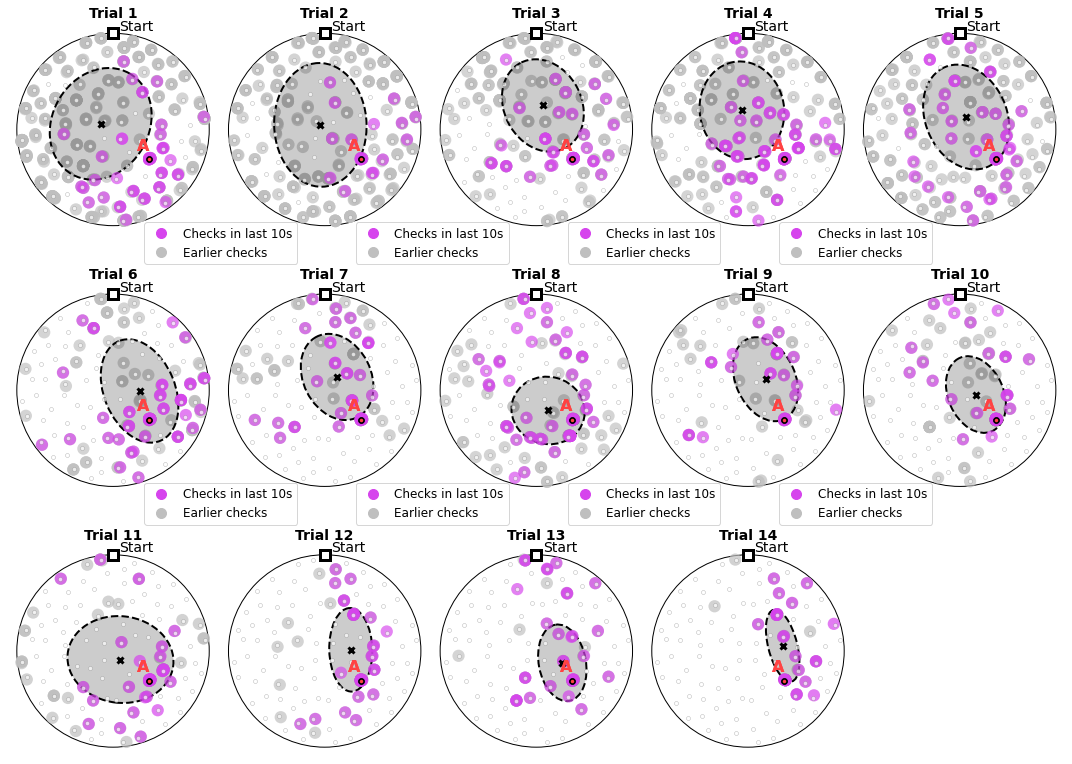

In [67]:
#import sys
#del sys.modules['modules.traj_analysis']
#del tran
#import modules.traj_analysis as tran

#import sys
#del sys.modules['modules.plot_func']
#del pltt
#import modules.plot_func as pltt

"""
###############
###############
###############
###############
############### P(check) -- trimmed trajectories, aligned targets
###############
###############
###############
###############
"""

#import sys
#del sys.modules['modules.plot_func']
#del pltt
#import modules.plot_func as pltt


ignore_entrance_positions = False
normalize_by              = 'max'
entrance_align_vector     = (0,1)

time_delay_before_end     = 10.0 + time_delay_after_food
show_arena_holes          = True
scale_point_size          = False
scale_color               = False
point_size                = 150
target_size               = 5
holes_size                = 4
color_checks_single       = numpy.array((214, 68, 237),dtype=float).reshape((1,3))/255
gray_shade_out_of_3s      = 0.75*numpy.ones((1,3))

all_trials_rt_rot   = plib.rotate_trial_file(copy.deepcopy(all_trials_rt),entrance_align_vector,True)
all_trials_rt_3s    = tran.slice_track_by_time(all_trials_rt_rot,dt= time_delay_before_end)
all_trials_rt_out3s = tran.slice_track_by_time(all_trials_rt_rot,dt=-time_delay_before_end)


# calculating the slowing down instants and positions in the 3 cm radius of holes
hole_horizon            = 3.5 # in cm (units is mouse.unit_r)  
use_velocity_minima     = True
velocity_min_prominence = 5.0 # cm/s



r_un_rt_3s  ,r_count_rt_3s  ,r_mean_rt_3s  ,r_cov_rt_3s  ,r_disp_rt_3s  ,r_eigdir_rt_3s   = misc.unpack_list_of_tuples([ tran.calc_number_of_checkings_per_hole(all_mice          ,hole_horizon,threshold_method='ampv',gamma=0.2,normalize_by=normalize_by,sort_result=True,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence                         ) for all_mice in all_trials_rt_3s    ])
r_un_rt     ,r_count_rt     ,r_mean_rt     ,r_cov_rt     ,r_disp_rt     ,r_eigdir_rt      = misc.unpack_list_of_tuples([ tran.calc_number_of_checkings_per_hole(all_mice          ,hole_horizon,threshold_method='ampv',gamma=0.2,normalize_by=normalize_by,sort_result=True,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence                         ) for all_mice in all_trials_rt_rot   ])


#d_near_target = 20.0 # cm; distance around target used to calculate the "near target dispersion of hole checks
#r_un_rt_near  ,r_count_rt_near  ,r_mean_rt_near  ,r_cov_rt_near  ,r_disp_rt_near  ,r_eigdir_rt_near   = misc.unpack_list_of_tuples([ tran.calc_number_of_checkings_per_hole(all_mice          ,hole_horizon,threshold_method='ampv',gamma=0.2,normalize_by=normalize_by,sort_result=True,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence                         ,r0=all_mice[0].r_target                   , radius_of_interest=d_near_target) for all_mice in all_trials_rt_rot ])
#r_un_ft_near  ,r_count_ft_near  ,r_mean_ft_near  ,r_cov_ft_near  ,r_disp_ft_near  ,r_eigdir_ft_near   = misc.unpack_list_of_tuples([ tran.calc_number_of_checkings_per_hole(all_mice          ,hole_horizon,threshold_method='ampv',gamma=0.2,normalize_by=normalize_by,sort_result=True,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence,grouping_hole_horizon=10,r0=all_mice[0].r_target                   , radius_of_interest=d_near_target) for all_mice in all_trials_ft_rot ])
#r_un_R180_near,r_count_R180_near,r_mean_R180_near,r_cov_R180_near,r_disp_R180_near,r_eigdir_R180_near =                              tran.calc_number_of_checkings_per_hole(all_trials_rt_R180,hole_horizon,threshold_method='ampv',gamma=0.2,normalize_by=normalize_by,sort_result=True,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence                         ,r0=all_trials_rt_R180[0].r_target_reverse , radius_of_interest=d_near_target)

show_panel_labels = False
is_dark_bg        = False
get_color         = lambda c_is_dark,c_not_dark: c_is_dark if is_dark_bg else c_not_dark
cmap_name         = pltt.get_cmap_plasma_inv_lum() #'plasma'
color_bg_dark     = plt.get_cmap(cmap_name)(numpy.linspace(0,1,100))[0]
color_red         = numpy.array((255, 66, 66,255))/255
color_blue        = numpy.array(( 10, 30,211,255))/255
color_green       = numpy.array(( 34,201, 98,255))/255# if is_dark_bg else numpy.array((17, 112, 50,255))/255
alpha_alt_target  = 0.35

trials_to_plot = numpy.arange(14)#numpy.array([ 0, 1, 4, 5, 6, 7, 12, 13 ])

fig,ax=plt.subplots(nrows=3,ncols=5,figsize=(22,22))
fig.patch.set_facecolor(get_color('k','w'))

default_panel_param  = dict(holes_args=dict(markersize=holes_size,markeredgewidth=0.4,color=0.5*numpy.ones(3),markerfacecolor=numpy.array((1,1,1,0.7)),fillstyle='full'),
                            panel_label_args=None,target1_label_args=None,is_dark_bg=is_dark_bg,cmap_name=cmap_name,
                            color_bg_dark='#000000',cmap_start_fraction=0.15,
                            start_args=dict(markerfacecolor='w',fillstyle='full',markeredgecolor='k',markeredgewidth=3),
                            scatter_args=dict(min_alpha=1.0),
                            ellipse_args=dict(facecolor=numpy.array((0,0,0,0.2))),
                            scale_point_size=scale_point_size,point_size=point_size,scale_color=scale_color)
plot_args_panel_rt1  = pltt._get_kwargs(dict(scatter_args       = dict(min_alpha=0.65),show_start=True,start_label_args=dict(fontsize=14,ha='left',va='bottom',pad=(4,0)),
                                             panel_label_args   = dict(fontdict=dict(fontsize=26,fontweight='bold')),
                                             target1_label      = 'A',
                                             target1_label_args = dict(ha='right',va='bottom',pad=(0,4)),
                                             color_target1      = color_red , alpha_target1=1.0,
                                             target2_label      = 'B',
                                             target1_args       = dict(markersize=target_size,markeredgewidth=1.5),
                                             color_target2      = color_blue,alpha_target2=1.0),**default_panel_param)
for k,(trial,aax) in enumerate(zip(trials_to_plot,ax.flatten()[:trials_to_plot.size])):
    pltt._plot_hole_check_spatial_distribution(all_trials_rt_rot[trial][0],
                                                         r_un_rt[trial],
                                                      r_count_rt[trial],
                                               all_trials_rt_rot[trial][0].r_target,
                                                       r_mean_rt[trial],
                                                     r_eigdir_rt[trial],
                                                       r_disp_rt[trial],
                                               ax=aax, color_checks_single=gray_shade_out_of_3s, show_holes=show_arena_holes, show_dispersion=True, **plot_args_panel_rt1)
    pltt._plot_hole_check_spatial_distribution(all_trials_rt_3s[trial][0],
                                                     r_un_rt_3s[trial],
                                                  r_count_rt_3s[trial],
                                               all_trials_rt_3s[trial][0].r_target,
                                                   r_mean_rt_3s[trial],
                                                 r_eigdir_rt_3s[trial],
                                                   r_disp_rt_3s[trial],
                                               ax=aax, panel_label=f'Trial {trial+1}', color_checks_single=color_checks_single, show_holes=False, show_arena=False, show_dispersion=False, **plot_args_panel_rt1)
    aax.plot(numpy.nan,numpy.nan,'o',c=color_checks_single ,markersize=10,label=f'Checks in last {time_delay_before_end-time_delay_after_food:g}s')
    aax.plot(numpy.nan,numpy.nan,'o',c=gray_shade_out_of_3s,markersize=10,label= 'Earlier checks'   )

#ellipse_args        = dict(show_center=True, facecolor='none', edgecolor='tab:green', linestyle='--', linewidth=2, zorder=10000)
#ellipse_center_args = dict(markersize=10,markeredgewidth=3,color='tab:green',marker='+',zorder=10001)
#pltt.plot_dispersion(r_mean_rt_near[ 0],r_eigdir_rt_near[ 0],r_disp_rt_near[ 0], ax=ax[0,0], center_args=ellipse_center_args, **ellipse_args)
#pltt.plot_dispersion(r_mean_rt_near[ 1],r_eigdir_rt_near[ 1],r_disp_rt_near[ 1], ax=ax[0,1], center_args=ellipse_center_args, **ellipse_args)
#pltt.plot_dispersion(r_mean_rt_near[ 5],r_eigdir_rt_near[ 5],r_disp_rt_near[ 5], ax=ax[0,2], center_args=ellipse_center_args, **ellipse_args)
#pltt.plot_dispersion(r_mean_rt_near[13],r_eigdir_rt_near[13],r_disp_rt_near[13], ax=ax[0,3], center_args=ellipse_center_args, **ellipse_args)

ax  = pltt.tight_arena_panels(ax,set_axis_off=True,adjust_title_position=False)
pltt.widen_axes_distance(ax,dy=-0.031)

ax[0,0].legend(loc='upper left', bbox_to_anchor=(0.62,0.09), fontsize=12)
ax[0,1].legend(loc='upper left', bbox_to_anchor=(0.62,0.09), fontsize=12)
ax[0,2].legend(loc='upper left', bbox_to_anchor=(0.62,0.09), fontsize=12)
ax[0,3].legend(loc='upper left', bbox_to_anchor=(0.62,0.09), fontsize=12)
ax[1,0].legend(loc='upper left', bbox_to_anchor=(0.62,0.09), fontsize=12)
ax[1,1].legend(loc='upper left', bbox_to_anchor=(0.62,0.09), fontsize=12)
ax[1,2].legend(loc='upper left', bbox_to_anchor=(0.62,0.09), fontsize=12)
ax[1,3].legend(loc='upper left', bbox_to_anchor=(0.62,0.09), fontsize=12)

#fig.suptitle('Static entrance hole checks',fontweight='bold',fontsize=17)

if save_output_figures:
    dark_label = 'dark' if is_dark_bg else 'white'
    fileName =  f'{output_dir}/distribution_{time_delay_before_end-time_delay_after_food:g}_SECONDS_hole_check_random_vs_static_{time_delay_after_food:g}s_{dark_label}.png'
    print(' ... saving ', fileName)
    plt.savefig( fileName,format='png',dpi=300,facecolor=get_color((0,0,0,1),(1,1,1,1)),bbox_inches='tight')

plt.show()

## Random target -- entrance analysis

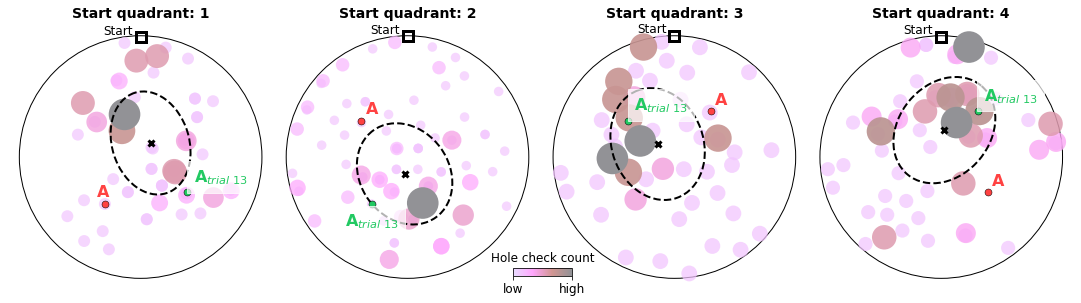

In [11]:
"""
###############
###############
###############
###############
############### P(check) -- random target, entrance analysis
###############
###############
###############
###############
"""

#import sys
#del sys.modules['modules.plot_func']
#del pltt
#import modules.plot_func as pltt

#all_trials_ft,trial_labels_ft = io.load_trial_file(mouse_traj_dir_ft,load_only_training_sessions_relative_target=True ,skip_15_relative_target=True ,use_extra_trials_relative_target=False,sort_by_trial=True,fix_nan=True,remove_after_food=False,align_to_top=False,group_by='trial',return_group_by_keys=True,max_trial_number=14)

entrance_align_vector     = (0,1)
ignore_entrance_positions = False
normalize_by              = 'max'
trial_to_show             = -1 # last
if trial_to_show == 0:
    print('... forcing trial_to_show == 1')
    trial_to_show = 1 # we wish to analyze the current trial relative to the previous one

# aligns entrances of all the files
all_trials_ft_rot        = plib.rotate_trial_file(copy.deepcopy(all_trials_ft),entrance_align_vector,True) # plib.align_targets(copy.deepcopy(all_trials_ft),(1,0))
trials_temp,_            = io.group_track_list(all_trials_ft_rot[trial_to_show-1], group_by='start_quadrant', get_key_group_func=lambda v: v, sortgroups_label='mouse_number', get_key_sortgroups_func=int ) # dict(SE=0,NE=1,SW=2,NW=3)[v]
all_trials_ft_startloc,_ = io.group_track_list(all_trials_ft_rot[trial_to_show]  , group_by='start_quadrant', get_key_group_func=lambda v: v, sortgroups_label='mouse_number', get_key_sortgroups_func=int ) # dict(SE=0,NE=1,SW=2,NW=3)[v]
startloc_prev_labels     = [ str(x[0].start_quadrant) for x in trials_temp ]
r_target_prev            = [ x[0].r_target            for x in trials_temp ]






# calculating the slowing down instants and positions in the 3 cm radius of holes
hole_horizon            = 3.0 # in cm (units is mouse.unit_r)  
use_velocity_minima     = True
velocity_min_prominence = 5.0 # cm/s

r_un_ft,r_count_ft,r_mean_ft,r_cov_ft,r_disp_ft,r_eigdir_ft = misc.unpack_list_of_tuples([
                                                                 tran.calc_number_of_checkings_per_hole(all_mice_from_startloc,hole_horizon,threshold_method='ampv',gamma=0.2,normalize_by=normalize_by,
                                                                                                        sort_result=True,ignore_entrance_positions=ignore_entrance_positions,grouping_hole_horizon=10,
                                                                                                        use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence)
                                                                                                        for all_mice_from_startloc in all_trials_ft_startloc ]
                                                                                                        )


show_panel_labels = False
is_dark_bg        = False
get_color         = lambda c_is_dark,c_not_dark: c_is_dark if is_dark_bg else c_not_dark
cmap_name         = pltt.get_cmap_plasma_inv_lum() #'plasma'
point_size        = 1e3
color_bg_dark     = 'k'#plt.get_cmap(cmap_name)(numpy.linspace(0,1,100))[0]
color_red         = numpy.array((255, 66, 66,255))/255
color_blue        = numpy.array(( 10, 30,211,255))/255
color_green       = numpy.array(( 34,201, 98,255))/255 #if is_dark_bg else numpy.array((17, 112, 50,255))/255
alpha_alt_target  = 0.35


fig,ax=plt.subplots(nrows=1,ncols=4,figsize=(22,8))
fig.patch.set_facecolor(get_color('k','w'))

default_panel_param = dict(panel_label_args=None,target1_label_args=None,is_dark_bg=is_dark_bg,cmap_name=cmap_name,point_size=point_size,color_bg_dark='#000000',cmap_start_fraction=0.15)
plot_args_panel_ft_startloc1 = pltt._get_kwargs(dict(scatter_args=dict(min_alpha=0.65),show_start=True,panel_label='Start quadrant: %g'%all_trials_ft_startloc[0][1].start_quadrant,target1_label='A',color_target1=color_red,alpha_target1=1.0,target2_label="A$_{trial\\ %s}$"%trials_temp[0][0].trial,color_target2=color_green,alpha_target2=1.0,target2_label_args=dict(va='bottom',ha='left'  ,pad=(3,3) ,backgroundcolor=get_color((0,0,0,0),(1,1,1,0.7))  ),target1_label_args=dict(ha='right')),**default_panel_param)
plot_args_panel_ft_startloc2 = pltt._get_kwargs(dict(scatter_args=dict(min_alpha=0.65),show_start=True,panel_label='Start quadrant: %g'%all_trials_ft_startloc[1][1].start_quadrant,target1_label='A',color_target1=color_red,alpha_target1=1.0,target2_label="A$_{trial\\ %s}$"%trials_temp[1][0].trial,color_target2=color_green,alpha_target2=1.0,target2_label_args=dict(va='top'   ,ha='center',pad=(0,-4),backgroundcolor=get_color((0,0,0,0),(1,1,1,0.7))  )),**default_panel_param)
plot_args_panel_ft_startloc3 = pltt._get_kwargs(dict(scatter_args=dict(min_alpha=0.65),show_start=True,panel_label='Start quadrant: %g'%all_trials_ft_startloc[2][1].start_quadrant,target1_label='A',color_target1=color_red,alpha_target1=1.0,target2_label="A$_{trial\\ %s}$"%trials_temp[2][0].trial,color_target2=color_green,alpha_target2=1.0,target2_label_args=dict(va='bottom',ha='left'  ,pad=(3,3) ,backgroundcolor=get_color((0,0,0,0),(1,1,1,0.7))  )),**default_panel_param)
plot_args_panel_ft_startloc4 = pltt._get_kwargs(dict(scatter_args=dict(min_alpha=0.65),show_start=True,panel_label='Start quadrant: %g'%all_trials_ft_startloc[3][1].start_quadrant,target1_label='A',color_target1=color_red,alpha_target1=1.0,target2_label="A$_{trial\\ %s}$"%trials_temp[3][0].trial,color_target2=color_green,alpha_target2=1.0,target2_label_args=dict(va='bottom',ha='left'  ,pad=(3,3) ,backgroundcolor=get_color((0,0,0,0),(1,1,1,0.7))  )),**default_panel_param)
pltt._plot_hole_check_spatial_distribution(all_trials_ft_startloc[0][0], r_un_ft[0], r_count_ft[0], all_trials_ft_startloc[0][0].r_target, r_mean_ft[0], r_eigdir_ft[0], r_disp_ft[0], ax=ax[0], r_target2=r_target_prev[0], **plot_args_panel_ft_startloc1)
pltt._plot_hole_check_spatial_distribution(all_trials_ft_startloc[1][0], r_un_ft[1], r_count_ft[1], all_trials_ft_startloc[1][0].r_target, r_mean_ft[1], r_eigdir_ft[1], r_disp_ft[1], ax=ax[1], r_target2=r_target_prev[1], **plot_args_panel_ft_startloc2)
pltt._plot_hole_check_spatial_distribution(all_trials_ft_startloc[2][0], r_un_ft[2], r_count_ft[2], all_trials_ft_startloc[2][0].r_target, r_mean_ft[2], r_eigdir_ft[2], r_disp_ft[2], ax=ax[2], r_target2=r_target_prev[2], **plot_args_panel_ft_startloc3)
pltt._plot_hole_check_spatial_distribution(all_trials_ft_startloc[3][0], r_un_ft[3], r_count_ft[3], all_trials_ft_startloc[3][0].r_target, r_mean_ft[3], r_eigdir_ft[3], r_disp_ft[3], ax=ax[3], r_target2=r_target_prev[3], **plot_args_panel_ft_startloc4)


ax  = pltt.tight_arena_panels(ax,set_axis_off=True,adjust_title_position=False)
cax = pltt._add_colorbar(ax[1],cmap_name,w_fraction_of_ax=0.22,h_fraction_of_ax=0.03,p0=(1.14,0.1),minmax_tick_labels=('low','high'),orientation='horizontal',title='Hole check count',titleArgs=dict(color=get_color('w','k'),fontsize=12),ticklabelsArgs=dict(color=get_color('w','k')))

if show_panel_labels:
    panel_labels = 'abcd'
    for a,lbl in zip(ax,list(panel_labels)):
        a.text(a.get_xlim()[0],a.get_ylim()[1],lbl+'.',ha='left',va='top',fontsize=30,fontweight='bold',color=get_color('w','k'))

if save_output_figures:
    trial_number = all_trials_ft_startloc[0][0].trial
    dark_label   = 'dark' if is_dark_bg else 'white'
    plt.savefig(  f'{output_dir}/distribution_hole_check_random_trial{trial_number}_{time_delay_after_food:g}s_{dark_label}.png',format='png',dpi=300,facecolor=get_color((0,0,0,1),(1,1,1,1)),bbox_inches='tight')


plt.show()

## Random target -- all trials

 *** saving ...  figs/paper/active_sensing/distribution_hole_check_random_all-trials_3s_detection-vmin_white.png
 *** saving ...  figs/paper/active_sensing/box_hole_check_near_targets_all-trials_3s_detection-vmin.png


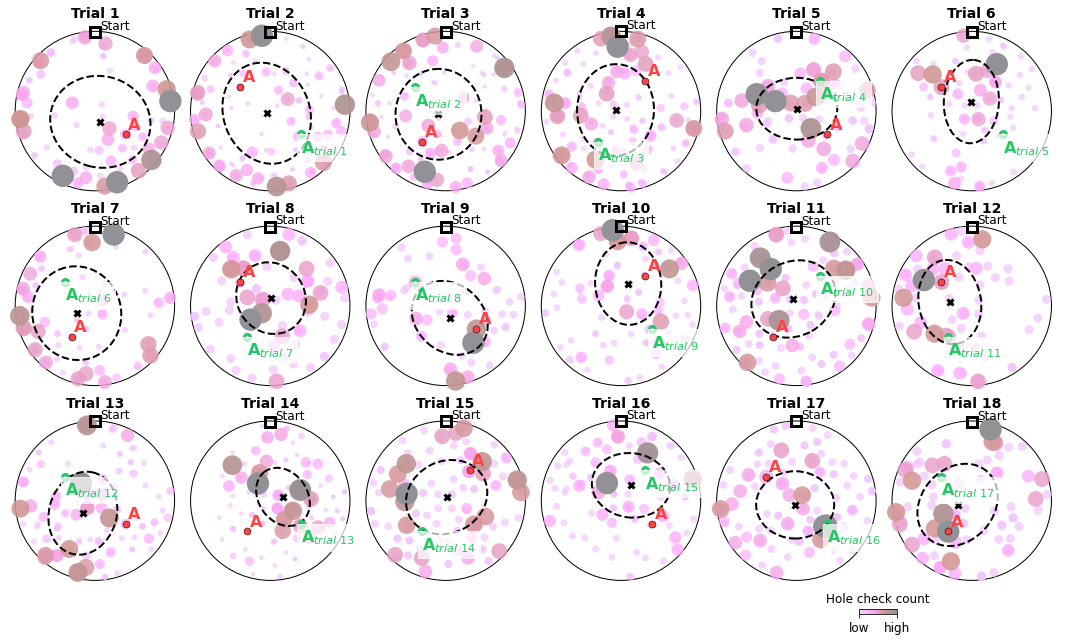

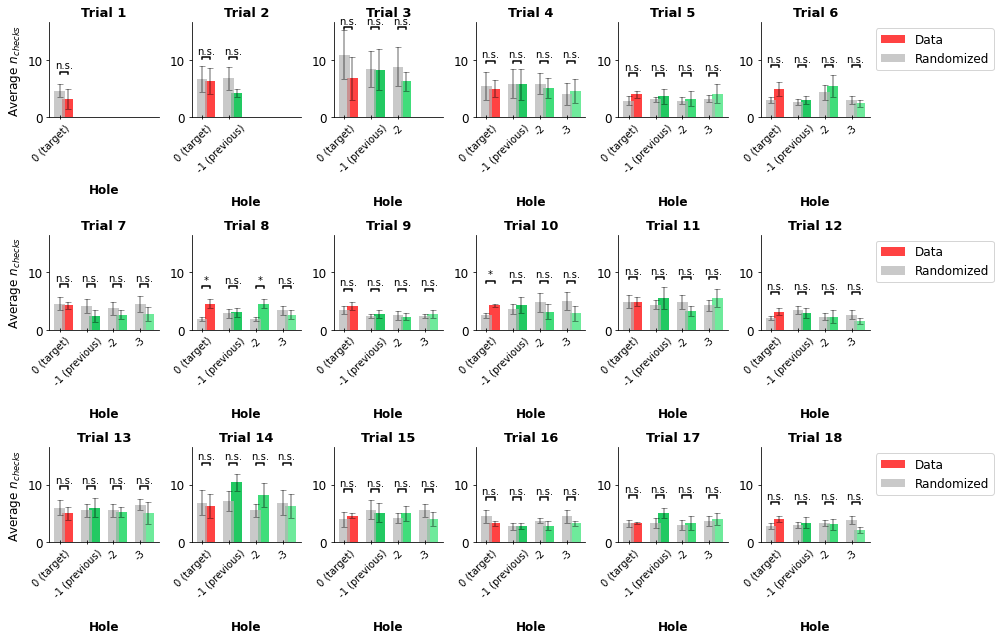

In [20]:
"""
###############
###############
###############
###############
############### P(check) -- trimmed trajectories, aligned targets
###############
###############
###############
###############
"""

#import sys
#del sys.modules['modules.traj_analysis']
#del tran
#import modules.traj_analysis as tran

ignore_entrance_positions = False
normalize_by              = 'max'
entrance_align_vector     = (0,1)

all_trials_ft_rot = plib.align_targets_group_by_start_quadrant(copy.deepcopy(all_trials_ft_full),entrance_align_vector)

trial_prev_label      = numpy.arange(len(all_trials_ft_rot))
r_target_prev_ft      = [numpy.ones(2)*numpy.nan]+[ trials[0].r_target for trials in all_trials_ft_rot ][:-1]


# calculating the slowing down instants and positions in the 3 cm radius of holes
hole_horizon            = 3.0 # in cm (units is mouse.unit_r)  
use_velocity_minima     = True
velocity_min_prominence = 5.0 # cm/s

r_un_ft,r_count_ft,r_mean_ft,r_cov_ft,r_disp_ft,r_eigdir_ft = misc.unpack_list_of_tuples([ tran.calc_number_of_checkings_per_hole(all_mice,hole_horizon,threshold_method='ampv',gamma=0.2,normalize_by=normalize_by,sort_result=True,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence,grouping_hole_horizon=10) for all_mice in all_trials_ft_rot ])



# aux variables for n_checks calculation
d_intertarget         = plib.get_intertarget_distance_static_entrance()
r_target_per_trial    = numpy.array([ numpy.mean(numpy.array([ tr.r_target for tr in all_mice ]),axis=0) for all_mice in all_trials_ft_rot ])
r_target_per_trial_un = r_target_per_trial[numpy.unique([ plib.get_start_location_quadrant(rr) for rr in r_target_per_trial] , return_index=True)[1]]
# r_target_per_trial_un -> index 0 is 1st quad target; 1 is 2nd quad; 2 is 3rd quad; 3 is 4th quad;
start_quad            = [ plib.get_start_location_quadrant(rr) for rr in r_target_per_trial ]
col_order_n_checks    = [ numpy.flip(start_quad[k-3:k+1]).astype(int)-1 for k in range(len(start_quad)) ] # the first index for each trial is always the current trial target; the immediate previous target is index 1, etc
col_order_n_checks    = [ numpy.concatenate((ind,   numpy.setdiff1d(numpy.arange(4),ind) if (ind.size < 4) else numpy.array([],dtype=int)   )) for ind in col_order_n_checks ]


sum_n_checks       = False # if True, sums all checks; if False, averages the checks over mice
ignore_zero_checks = True  # if True, ignores n_checks=0 when summing or averaging
target_horizon     = numpy.min(d_intertarget)/2.0 # 15.0 # cm
n_checks           = [ tran.calc_number_of_checkings_near_position(all_trials_ft_rot,r0,target_horizon,hole_horizon,threshold_method='ampv',gamma=0.2,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for r0 in r_target_per_trial_un ]
n_checks_arr       = numpy.moveaxis(numpy.array(n_checks),0,1).astype(float)

n_checks_randomized     = [ tran.calc_number_of_checkings_near_position(all_trials_ft_rot,r0,target_horizon,hole_horizon,threshold_method='ampv',gamma=0.2,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence,randomize_check_positions=True) for r0 in r_target_per_trial_un ]
n_checks_arr_randomized = numpy.moveaxis(numpy.array(n_checks_randomized),0,1).astype(float)

if ignore_zero_checks:
    n_checks_arr[n_checks_arr==0]=numpy.nan
accum_func     = numpy.nansum if sum_n_checks else misc.nanmean
n_checks_mmean = misc.sort_each_row(  accum_func(n_checks_arr,axis=2), col_order_n_checks)
n_checks_mstd  = misc.sort_each_row(misc.nanserr(n_checks_arr,axis=2), col_order_n_checks)
n_checks_mmean_randomized = misc.sort_each_row(  accum_func(n_checks_arr_randomized,axis=2), col_order_n_checks)
n_checks_mstd_randomized  = misc.sort_each_row(misc.nanserr(n_checks_arr_randomized,axis=2), col_order_n_checks)


p_threshold = 0.05
res_ttest = misc.check_p_values([ misc.ttest(n_checks_arr_randomized[k,:,:].T,n_checks_arr[k,:,:].T,zscore_to_controls=True,nan_policy='omit',alternative='two-sided') for k in range(n_checks_arr_randomized.shape[0]) ],
                          p_threshold=p_threshold)




is_dark_bg       = False
get_color        = lambda c_is_dark,c_not_dark: c_is_dark if is_dark_bg else c_not_dark
cmap_name         = pltt.get_cmap_plasma_inv_lum() #'plasma'
point_size       = 0.5e3
color_bg_dark    = plt.get_cmap(cmap_name)(numpy.linspace(0,1,100))[0]
color_red        = numpy.array((255, 66, 66,255))/255
color_blue       = numpy.array(( 10, 30,211,255))/255
color_green      = numpy.array(( 34,201, 98,255))/255# if is_dark_bg else numpy.array((17, 112, 50,255))/255
alpha_alt_target = 0.35

fig,ax=plt.subplots(nrows=3,ncols=6,figsize=(22,18))
fig.patch.set_facecolor(get_color('k','w'))

default_panel_param = dict(panel_label_args=None,target1_label_args=None,is_dark_bg=is_dark_bg,cmap_name=cmap_name,point_size=point_size,color_bg_dark='#000000',cmap_start_fraction=0.15)
plot_args_panel_ft1 = pltt._get_kwargs(dict(scatter_args=dict(min_alpha=0.65),show_start=True,start_label_args=dict(ha='left',pad=(4,0)),panel_label='' ,panel_label_args=dict(fontdict=dict(fontsize=7,fontweight='bold')),target1_label='A',color_target1=color_red ,alpha_target1=1.0,target2_label='B',color_target2=color_blue,alpha_target2=1.0),**default_panel_param)
for k in range(len(all_trials_ft_rot)):
    i,j = numpy.unravel_index(k,ax.shape)
    plot_args                = copy.deepcopy(plot_args_panel_ft1)
    plot_args['panel_label'] = 'Trial %s'%all_trials_ft_rot[k][0].trial
    pltt._plot_hole_check_spatial_distribution(all_trials_ft_rot[k][0],r_un_ft[k] ,r_count_ft[k] ,all_trials_ft_rot[k][0].r_target ,r_mean_ft[k] ,r_eigdir_ft[k] ,r_disp_ft[k] , ax=ax[i,j], **plot_args)
    pltt.plot_point(r_target_prev_ft[k],fmt='o',color=color_green ,markersize=6, ax=ax[i,j], pointArgs=dict(markeredgewidth=3, label='A$_{trial\\ %d}$'%trial_prev_label[k],labelArgs=dict(fontsize=16,va='top',ha='left'  , fontweight='bold',color=color_green ,pad=(0,-3) , backgroundcolor=get_color((0,0,0,0),(1,1,1,0.7))                          )))

ax  = pltt.tight_arena_panels(ax,set_axis_off=True,adjust_title_position=False,dy_amid_panels=0.015)
cax = pltt._add_colorbar(ax[-1,-2],cmap_name,w_fraction_of_ax=0.22,h_fraction_of_ax=0.03,p0=(1.1,-0.1),minmax_tick_labels=('low','high'),orientation='horizontal',title='Hole check count',titleArgs=dict(color=get_color('w','k'),fontsize=12),ticklabelsArgs=dict(color=get_color('w','k')))


save_output_figures = True

if save_output_figures:
    dark_label      = 'dark' if is_dark_bg else 'white'
    detection_label = 'vmin' if use_velocity_minima else 'slowdown'
    pltt.savefig(f'{output_dir}/distribution_hole_check_random_all-trials_{time_delay_after_food:g}s_detection-{detection_label}_{dark_label}.png', format='png',dpi=300,facecolor=get_color((0,0,0,1),(1,1,1,1)),bbox_inches='tight')



#tick_labels_base    = [ 'A', 'A', 'A', 'A' ]
add_spacing         = lambda s,k: s+('\n \n ' if k < 2 else '')
tick_labels_base    = [ '0 (target)', '-1 (previous)', '-2', '-3' ]
color_for_bars      = [color_red,color_green,numpy.array((64, 221, 122,255))/255,numpy.array((110, 234, 155,255))/255]
color_for_bars_rand = [0.7*numpy.ones(4) for _ in range(4)]

show_previous_target_equal_current_in_tick_labels = False

xtick_rotation   = 45

fig,ax_all=plt.subplots(nrows=3,ncols=6,sharex=False,sharey=True,figsize=(14,9))
for k,(ax,ind) in enumerate(zip(ax_all.flatten(),col_order_n_checks)):
    ind_to_plot         = numpy.arange(numpy.min((k+1,4)))
    n                   = n_checks_mmean[k,ind_to_plot]
    n_std               = n_checks_mstd[k,ind_to_plot]
    n_randomized        = n_checks_mmean_randomized[k,ind_to_plot]
    n_std_randomized    = n_checks_mstd_randomized[k,ind_to_plot]
    # adding asterisk to tick labels with significant difference between n_checks and its randomized distribution
    #tick_labels_base_tt = [ add_spacing(tl + ('*' if res else ''),nn) for nn,(tl,res) in enumerate(zip(tick_labels_base,res_ttest[k][ind])) ]
    tick_labels         = numpy.array(tick_labels_base_tt,dtype=str)
    bar_position        = numpy.arange(n.size) + 0.0
    bar_position_rand   = numpy.arange(n_randomized.size) - 0.3
    ax.bar(bar_position     , n           , yerr=n_std           ,tick_label=tick_labels[ind_to_plot],width=0.4,color=color_for_bars     ,capsize=3,ecolor=[0,0,0,0.4],label='Data')
    ax.bar(bar_position_rand, n_randomized, yerr=n_std_randomized,tick_label=tick_labels[ind_to_plot],width=0.4,color=color_for_bars_rand,capsize=3,ecolor=[0,0,0,0.4],label='Randomized')
    for p1,n1,p2,n2,result_ttest in zip(bar_position_rand,n_randomized,bar_position,n,res_ttest[k][ind]):
        is_significant_txt  = '*' if result_ttest else 'n.s.'
        pltt._annotate_boxplot(ax, 0, 1, [n_randomized+n_std_randomized/2,n+n_std/2], TXT=is_significant_txt, dy_txt=0.2,dy_bracket=0.3,bracket_size=0.2, color='k', is_log_scale=False, x1_plot_coord=p1, x2_plot_coord=p2, line_args=None, txt_args=None, symbol_args=None)
    ax.set_title('Trial %d'%(k+1),fontweight='bold',fontsize=13)
    ax.tick_params(axis='x',which='major',rotation=xtick_rotation,top=True,direction='inout')
    ax.set_xticklabels(tick_labels[ind_to_plot], fontdict=dict(family='sans-serif',verticalalignment='top',horizontalalignment='center',size=10)) #fontweight='bold'
    ax.set_xlabel('Hole',fontsize=12,fontweight='bold')
    pltt.set_box_axis(ax, False)
ax_all[ 0,0].set_xlim(ax_all[-1,-1].get_xlim())
ax_all[ 0,1].set_xlim(ax_all[-1,-1].get_xlim())
ax_all[ 0,2].set_xlim(ax_all[-1,-1].get_xlim())
ax_all[ 0,0].set_ylabel('Average $n_{checks}$',fontsize=12)
ax_all[ 1,0].set_ylabel('Average $n_{checks}$',fontsize=12)
ax_all[ 2,0].set_ylabel('Average $n_{checks}$',fontsize=12)
ax_all[0,-1].legend(fontsize=12,bbox_to_anchor=(1,1),loc='upper left')
ax_all[1,-1].legend(fontsize=12,bbox_to_anchor=(1,1),loc='upper left')
ax_all[2,-1].legend(fontsize=12,bbox_to_anchor=(1,1),loc='upper left')

fig.tight_layout()


if save_output_figures:
    detection_label = 'vmin' if use_velocity_minima else 'slowdown'
    pltt.savefig(f'{output_dir}/box_hole_check_near_targets_all-trials_{time_delay_after_food:g}s_detection-{detection_label}.png',format='png',dpi=300,facecolor=(1,1,1,1),bbox_inches='tight')

plt.show()

## 2 targets

 ... saving  figs/paper/active_sensing/distribution_hole_check_2targets_3s_white.png


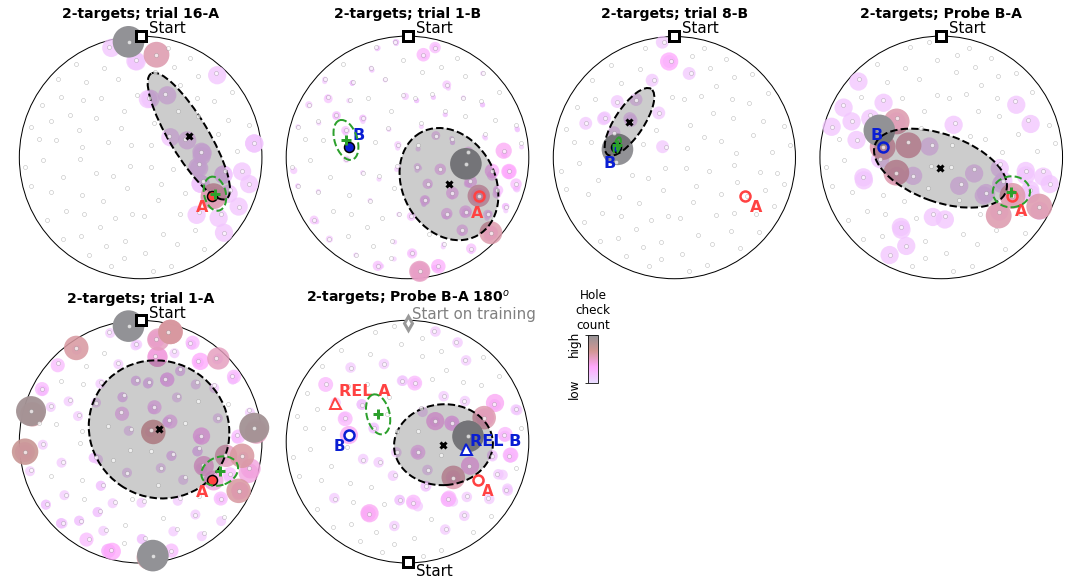

In [3]:
"""
###############
###############
###############
###############
############### P(check) -- trimmed trajectories, aligned targets
###############
###############
###############
###############
"""

#import sys
#del sys.modules['modules.plot_func']
#del pltt
#import modules.plot_func as pltt

#import sys
#del sys.modules['modules.traj_analysis']
#del tran
#import modules.traj_analysis as tran

# '16'    : [35]       # mice to omit in these trials -- 16: trial 16-A; 26: trial 8-B
# '26'    : [33,35]    # mice to omit in these trials -- 16: trial 16-A; 26: trial 8-B
# 'Probe2': [34,58,60] # mice to omit in these trials -- 16: trial 16-A; 26: trial 8-B

omit_mice = { '16'    : [35]       ,
              '26'    : [33,35]    ,
              'Probe2': [34,58,60] }

ignore_entrance_positions = False
normalize_by              = 'max'
entrance_align_vector     = (0,1)

trAidx = 15

all_trials_l1_rot = plib.rotate_trial_file(tran.remove_mice_from_track_list(copy.deepcopy(all_trials_l1),omit_mice),entrance_align_vector,True)
all_trials_l2_rot = plib.rotate_trial_file(tran.remove_mice_from_track_list(copy.deepcopy(all_trials_l2),omit_mice),entrance_align_vector,True)
all_trials_p2_rot = plib.rotate_trial_file(tran.remove_mice_from_track_list(copy.deepcopy(all_trials_p2),omit_mice),entrance_align_vector,True)

#trial_prev_label  = numpy.arange(len(all_trials_ft_rot))
#r_target_prev_ft  = [numpy.ones(2)*numpy.nan]+[ trials[0].r_target for trials in all_trials_ft_rot ][:-1]

# calculating the slowing down instants and positions in the 3 cm radius of holes
hole_horizon            = 3.0 # in cm (units is mouse.unit_r)  
use_velocity_minima     = True
velocity_min_prominence = 5.0 # cm/s

r_un_l1     ,r_count_l1     ,r_mean_l1     ,r_cov_l1     ,r_disp_l1     ,r_eigdir_l1      = misc.unpack_list_of_tuples([ tran.calc_number_of_checkings_per_hole(all_mice          ,hole_horizon,threshold_method='ampv',gamma=0.2,normalize_by=normalize_by,sort_result=True,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for all_mice in all_trials_l1_rot ])
r_un_l2     ,r_count_l2     ,r_mean_l2     ,r_cov_l2     ,r_disp_l2     ,r_eigdir_l2      = misc.unpack_list_of_tuples([ tran.calc_number_of_checkings_per_hole(all_mice          ,hole_horizon,threshold_method='ampv',gamma=0.2,normalize_by=normalize_by,sort_result=True,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence) for all_mice in all_trials_l2_rot ])
r_un_p2     ,r_count_p2     ,r_mean_p2     ,r_cov_p2     ,r_disp_p2     ,r_eigdir_p2      =                              tran.calc_number_of_checkings_per_hole(all_trials_p2_rot ,hole_horizon,threshold_method='ampv',gamma=0.2,normalize_by=normalize_by,sort_result=True,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence)
r_un_p2_R180,r_count_p2_R180,r_mean_p2_R180,r_cov_p2_R180,r_disp_p2_R180,r_eigdir_p2_R180 =                              tran.calc_number_of_checkings_per_hole(all_trials_p2_R180,hole_horizon,threshold_method='ampv',gamma=0.2,normalize_by=normalize_by,sort_result=True,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence)

d_near_target = 20.0 # cm; distance around target used to calculate the "near target dispersion of hole checks


r_un_l1_near     ,r_count_l1_near     ,r_mean_l1_near     ,r_cov_l1_near     ,r_disp_l1_near     ,r_eigdir_l1_near      = misc.unpack_list_of_tuples([ tran.calc_number_of_checkings_per_hole(all_mice          ,hole_horizon,threshold_method='ampv',gamma=0.2,normalize_by=normalize_by,sort_result=True,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence,r0=all_mice[0].r_target              , radius_of_interest=d_near_target) for all_mice in all_trials_l1_rot ])
r_un_l2_near     ,r_count_l2_near     ,r_mean_l2_near     ,r_cov_l2_near     ,r_disp_l2_near     ,r_eigdir_l2_near      = misc.unpack_list_of_tuples([ tran.calc_number_of_checkings_per_hole(all_mice          ,hole_horizon,threshold_method='ampv',gamma=0.2,normalize_by=normalize_by,sort_result=True,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence,r0=all_mice[0].r_target              , radius_of_interest=d_near_target) for all_mice in all_trials_l2_rot ])
r_un_p2_near     ,r_count_p2_near     ,r_mean_p2_near     ,r_cov_p2_near     ,r_disp_p2_near     ,r_eigdir_p2_near      =                              tran.calc_number_of_checkings_per_hole(all_trials_p2_rot ,hole_horizon,threshold_method='ampv',gamma=0.2,normalize_by=normalize_by,sort_result=True,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence,r0=all_trials_p2_rot[0].r_target_alt , radius_of_interest=d_near_target)
r_un_p2_R180_near,r_count_p2_R180_near,r_mean_p2_R180_near,r_cov_p2_R180_near,r_disp_p2_R180_near,r_eigdir_p2_R180_near =                              tran.calc_number_of_checkings_per_hole(all_trials_p2_R180,hole_horizon,threshold_method='ampv',gamma=0.2,normalize_by=normalize_by,sort_result=True,ignore_entrance_positions=ignore_entrance_positions,use_velocity_minima=use_velocity_minima,velocity_min_prominence=velocity_min_prominence,r0=all_trials_p2_R180[0].r_target_alt, radius_of_interest=d_near_target)


show_panel_labels = False
is_dark_bg        = False
get_color         = lambda c_is_dark,c_not_dark: c_is_dark if is_dark_bg else c_not_dark
cmap_name         = pltt.get_cmap_plasma_inv_lum() #'plasma'
point_size        = 1e3
color_bg_dark     = plt.get_cmap(cmap_name)(numpy.linspace(0,1,100))[0]
color_red         = numpy.array((255, 66, 66,255))/255
color_blue        = numpy.array(( 10, 30,211,255))/255
color_green       = numpy.array(( 34,201, 98,255))/255# if is_dark_bg else numpy.array((17, 112, 50,255))/255
alpha_alt_target  = 1

fig,ax=plt.subplots(nrows=2,ncols=4,figsize=(22,12))
fig.patch.set_facecolor(get_color('k','w'))

default_panel_param      = dict(show_holes=True,holes_args=dict(markersize=4,markeredgewidth=0.4,color=0.5*numpy.ones(3),markerfacecolor=numpy.array((1,1,1,0.7)),fillstyle='full'),
                                start_args=dict(markerfacecolor='w',fillstyle='full',markeredgecolor='k',markeredgewidth=3),
                                panel_label_args=None,target1_label_args=None,is_dark_bg=is_dark_bg,cmap_name=cmap_name,
                                point_size=point_size,color_bg_dark='#000000',cmap_start_fraction=0.15,
                                start_label_args=dict(fontsize=15,ha='left',va='bottom',pad=(4,0)),
                                scatter_args=dict(min_alpha=0.7),
                                ellipse_args=dict(facecolor=numpy.array((0,0,0,0.2))))
plot_args_panel_l11      = pltt._get_kwargs(dict(scatter_args       = dict(min_alpha=0.65),
                                                 show_start         = True,
                                                 panel_label        = '2-targets; trial 1-A'                 ,
                                                 target1_label      = 'A',
                                                 target1_args       = dict(markersize=10,markeredgewidth=1.5),
                                                 color_target1      = color_red ,alpha_target1=1.0                 ,
                                                 target1_label_args = dict(ha='right',va='top'   ,pad=(-2,-2)) ,
                                                 target2_label      = 'A',
                                                 color_target2      = color_red ,alpha_target2=1.0             ),**default_panel_param)
plot_args_panel_l12      = pltt._get_kwargs(dict(scatter_args=dict(min_alpha=0.65),
                                                 show_start=True,
                                                 panel_label=f'2-targets; trial {trAidx+1}-A'        ,
                                                 target1_label='A',
                                                 target1_args       = dict(markersize=10,markeredgewidth=1.5),
                                                 color_target1=color_red ,alpha_target1=1.0                 ,
                                                 target1_label_args=dict(ha='right',va='top'   ,pad=(-2,-2)) ,
                                                 target2_label='A',
                                                 color_target2=color_red ,alpha_target2=alpha_alt_target),**default_panel_param)
plot_args_panel_l21      = pltt._get_kwargs(dict(scatter_args=dict(min_alpha=0.65),
                                                 show_start=True,
                                                 panel_label= '2-targets; trial 1-B'                 ,
                                                 target1_label='B',
                                                 color_target1=color_blue,alpha_target1=alpha_alt_target    ,
                                                 target1_label_args=dict()                                   ,
                                                 target2_label='A',
                                                 color_target2=color_red ,alpha_target2=1.0             ,
                                                 target2_label_args=dict(ha='center',va='top',pad=(-1,-5)),
                                                 target1_args       = dict(markersize=10,markeredgewidth=1.5),
                                                 target2_args       = dict(markersize=10,markeredgewidth=2.5),
                                                 is_target2_present=False),**default_panel_param)
plot_args_panel_l22      = pltt._get_kwargs(dict(scatter_args=dict(min_alpha=0.65),
                                                 show_start=True,
                                                 panel_label= '2-targets; trial 8-B'                 ,
                                                 target1_label='B',
                                                 color_target1=color_blue,alpha_target1=1.0                 ,
                                                 target1_label_args=dict(ha='right',va='top'   ,pad=(0,-4))  ,
                                                 target2_label='A',
                                                 color_target2=color_red ,alpha_target2=alpha_alt_target,
                                                 target2_label_args=dict(ha='left'  ,va='top',pad=(2,-2)) ,
                                                 target1_args       = dict(markersize=10,markeredgewidth=1.5),
                                                 target2_args       = dict(markersize=10,markeredgewidth=2.5),
                                                 is_target2_present=False),**default_panel_param)
plot_args_panel_p2       = pltt._get_kwargs(dict(scatter_args=dict(min_alpha=0.65),
                                                 show_start=True,
                                                 panel_label= '2-targets; Probe B-A'    ,
                                                 target1_label='B',
                                                 color_target1=color_blue,alpha_target1=1.0                 ,
                                                 target1_label_args=dict(ha='right',va='bottom',pad=(0,2))   ,
                                                 target2_label='A',
                                                 color_target2=color_red ,alpha_target2=1.0             ,
                                                 target2_label_args=dict(ha='left'  ,va='top',pad=(1,-4)) ,
                                                 target1_args       = dict(markersize=10,markeredgewidth=2.5),
                                                 target2_args       = dict(markersize=10,markeredgewidth=2.5),
                                                 is_target1_present=False,is_target2_present=False),**default_panel_param)
plot_args_panel_p2_R180  = pltt._get_kwargs(dict(scatter_args=dict(min_alpha=0.65),
                                                 show_start=True,
                                                 start_label_args=dict(ha='left',va='top',pad=(4,-1),fontsize=15),
                                                 panel_label= '2-targets; Probe B-A 180$^o$'    ,
                                                 target1_label='REL B',
                                                 color_target1=color_blue,alpha_target1=1.0                 ,
                                                 target1_label_args=dict(ha='left',va='bottom',pad=(2,0))   ,
                                                 target2_label='REL A',
                                                 color_target2=color_red ,alpha_target2=1.0             ,
                                                 target2_label_args=dict(ha='left'  ,va='bottom',pad=(2,2)) ,
                                                 target1_args       = dict(marker='^',markersize=11,markerfacecolor='w',markeredgewidth=2,fillstyle='full'),
                                                 target2_args       = dict(marker='^',markersize=11,markerfacecolor='w',markeredgewidth=2,fillstyle='full'),
                                                 is_target1_present=False,is_target2_present=False),**default_panel_param)
pltt._plot_hole_check_spatial_distribution(all_trials_l1_rot[  0   ][0],r_un_l1[  0   ],r_count_l1[  0   ],all_trials_l1_rot[0][0].r_target,r_mean_l1[  0   ],r_eigdir_l1[  0   ],r_disp_l1[  0   ],ax=ax[1,0],r_target2=None                                ,**plot_args_panel_l11)
pltt._plot_hole_check_spatial_distribution(all_trials_l1_rot[trAidx][0],r_un_l1[trAidx],r_count_l1[trAidx],all_trials_l1_rot[0][0].r_target,r_mean_l1[trAidx],r_eigdir_l1[trAidx],r_disp_l1[trAidx],ax=ax[0,0],r_target2=None                                ,**plot_args_panel_l12)
pltt._plot_hole_check_spatial_distribution(all_trials_l2_rot[  0   ][0],r_un_l2[  0   ],r_count_l2[  0   ],all_trials_l2_rot[0][0].r_target,r_mean_l2[  0   ],r_eigdir_l2[  0   ],r_disp_l2[  0   ],ax=ax[0,1],r_target2=all_trials_l2_rot[0][0].r_target_alt,**plot_args_panel_l21)
pltt._plot_hole_check_spatial_distribution(all_trials_l2_rot[ -1   ][0],r_un_l2[ -1   ],r_count_l2[ -1   ],all_trials_l2_rot[0][0].r_target,r_mean_l2[ -1   ],r_eigdir_l2[ -1   ],r_disp_l2[ -1   ],ax=ax[0,2],r_target2=all_trials_l2_rot[0][0].r_target_alt,**plot_args_panel_l22)
pltt._plot_hole_check_spatial_distribution(all_trials_p2_rot[0]        ,r_un_p2        ,r_count_p2        ,all_trials_p2_rot[0].r_target   ,r_mean_p2        ,r_eigdir_p2        ,r_disp_p2        ,ax=ax[0,3],r_target2=all_trials_p2_rot[0].r_target_alt   ,**plot_args_panel_p2 )
pltt._plot_hole_check_spatial_distribution(all_trials_p2_R180[0]       ,r_un_p2_R180   ,r_count_p2_R180   ,all_trials_p2_R180[0].r_target  ,r_mean_p2_R180   ,r_eigdir_p2_R180   ,r_disp_p2_R180   ,ax=ax[1,1],r_target2=all_trials_p2_R180[0].r_target_alt  ,**plot_args_panel_p2_R180 )

color_tgt_blu = numpy.array(( 10, 30,211,255))/255
color_tgt_red = numpy.array((255, 66, 66,255))/255

r_start_training = all_trials_p2_R180[0].r_start.copy();r_start_training[1] = -r_start_training[1]+1.5
pltt.plot_point(r_start_training,'Start on training',ax=ax[1,1],fmt='d',color=0.6*numpy.ones(3),pointArgs=dict(markeredgewidth=3,markersize=10,markerfacecolor='w',fillstyle='full'),pad=(2,2),ha='left',fontsize=15,labelcolor=0.5*numpy.ones(3))
pltt.plot_point(all_trials_p2_R180[0].r_target_reverse    ,'B',ax=ax[1,1],fmt='o',color=color_tgt_blu,pointArgs=dict(markeredgewidth=2.5,markersize=10,markerfacecolor='w',fillstyle='full'),pad=(-2,-2),ha='right',va='top',fontsize=15,labelcolor=color_tgt_blu,fontweight='bold')
pltt.plot_point(all_trials_p2_R180[0].r_target_alt_reverse,'A',ax=ax[1,1],fmt='o',color=color_tgt_red,pointArgs=dict(markeredgewidth=2.5,markersize=10,markerfacecolor='w',fillstyle='full'),pad=(2,-2),ha='left' ,va='top',fontsize=15,labelcolor=color_tgt_red,fontweight='bold')




ellipse_args        = dict(show_center=True, facecolor='none', edgecolor='tab:green', linestyle='--', linewidth=2, zorder=10000)
ellipse_center_args = dict(markersize=10,markeredgewidth=3,color='tab:green',marker='+',zorder=10001)
pltt.plot_dispersion(r_mean_l1_near[  0   ],r_eigdir_l1_near[  0   ],r_disp_l1_near[  0   ], ax=ax[1,0], center_args=ellipse_center_args, **ellipse_args)
pltt.plot_dispersion(r_mean_l1_near[trAidx],r_eigdir_l1_near[trAidx],r_disp_l1_near[trAidx], ax=ax[0,0], center_args=ellipse_center_args, **ellipse_args)
pltt.plot_dispersion(r_mean_l2_near[  0   ],r_eigdir_l2_near[  0   ],r_disp_l2_near[  0   ], ax=ax[0,1], center_args=ellipse_center_args, **ellipse_args)
pltt.plot_dispersion(r_mean_l2_near[ -1   ],r_eigdir_l2_near[ -1   ],r_disp_l2_near[ -1   ], ax=ax[0,2], center_args=ellipse_center_args, **ellipse_args)
pltt.plot_dispersion(r_mean_p2_near        ,r_eigdir_p2_near        ,r_disp_p2_near        , ax=ax[0,3], center_args=ellipse_center_args, **ellipse_args)
pltt.plot_dispersion(r_mean_R180_near      ,r_eigdir_R180_near      ,r_disp_R180_near      , ax=ax[1,1], center_args=ellipse_center_args, **ellipse_args)




ax  = pltt.tight_arena_panels(ax,set_axis_off=True,adjust_title_position=False,dy_amid_panels=0.02)
#cax = pltt._add_colorbar(ax[0,1],cmap_name,w_fraction_of_ax=0.22,h_fraction_of_ax=0.03,p0=(1.14,0.1),minmax_tick_labels=('low','high'),orientation='horizontal',title='Hole check count',titleArgs=dict(color=get_color('w','k'),fontsize=12),ticklabelsArgs=dict(color=get_color('w','k')))

cax = pltt._add_colorbar(ax[0,1],cmap_name,w_fraction_of_ax=0.04,h_fraction_of_ax=0.18,p0=(1.24,-0.15),minmax_tick_labels=('low','high'),orientation='vertical',ticklocation='left',title='Hole\ncheck\ncount',titleArgs=dict(color=get_color('w','k'),fontsize=12),ticklabelsArgs=dict(color=get_color('w','k'),rotation=90))
#cax[0].ax.yaxis.set_ticks_position('left')

save_output_figures=True
if save_output_figures:
    dark_label = 'dark' if is_dark_bg else 'white'
    fileName =  f'{output_dir}/distribution_hole_check_2targets_{time_delay_after_food:g}s_{dark_label}.png'
    print(' ... saving ', fileName)
    plt.savefig( fileName,format='png',dpi=300,facecolor=get_color((0,0,0,1),(1,1,1,1)),bbox_inches='tight')

plt.show()